# Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv
/kaggle/input/demand-forecasting-kernels-only/train.csv
/kaggle/input/demand-forecasting-kernels-only/test.csv


# Data Preprocessing

In [3]:
df = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv')

In [4]:
test = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv')

In [5]:
df.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [6]:
df.tail(10)

,date,store,item,sales
912990,2017-12-22,10,50,75
912991,2017-12-23,10,50,70
912992,2017-12-24,10,50,76
912993,2017-12-25,10,50,51
912994,2017-12-26,10,50,41
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [7]:
print(f'df.columns   : {df.columns}')
print(f'df.shape     : {df.shape}')

df.columns   : Index(['date', 'store', 'item', 'sales'], dtype='object')
df.shape     : (913000, 4)


In [8]:
dtypes_cnt = df.dtypes.groupby(df.dtypes).size()
dtypes_col = df.columns.groupby(df.dtypes)

In [9]:
print("dtypes_cnt    :", dtypes_cnt.to_dict())
print("dtypes_col    :", dtypes_col)

dtypes_cnt    : {dtype('int64'): 3, dtype('O'): 1}
dtypes_col    : {int64: ['store', 'item', 'sales'], object: ['date']}


In [10]:
df.select_dtypes(include=['int64', 'float64']).describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [11]:
df.select_dtypes(include=['object']).describe()

,date
count,913000
unique,1826
top,2017-12-31
freq,500


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [13]:
df.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [14]:
print('column name'.ljust(20), '# unique values')
for col in df.columns:
    print(col.ljust(20), '=>', len(df[col].unique()))

column name          # unique values
date                 => 1826
store                => 10
item                 => 50
sales                => 213


In [15]:
categorical_columns = [col for col in df.columns if len(df[col].unique()) < 50]

In [16]:
for col in categorical_columns:
    print(col.ljust(20), '=>', df[col].unique())

store                => [ 1  2  3  4  5  6  7  8  9 10]


# Data Visualization

In [17]:
# Distribution Plots:
def my_histplot(df, col, ax):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Histogram Plot of {col}')
def my_distplot(df, col, ax):
    sns.distplot(df[col], ax=ax)
    ax.set_title(f'Distribution Plot of {col}')
def my_kdeplot(df, col, ax):
    sns.kdeplot(df[col], ax=ax, fill=True)
    ax.set_title(f'KDE Plot of {col}')

# Relational Plots:
def my_scatterplot(df, col, ax):
    sns.scatterplot(df[col], ax=ax)
    ax.set_title(f'Scatter Plot of {col}')
def my_lineplot(df, col, ax):
    sns.lineplot(df[col], ax=ax)
    ax.set_title(f'Line Plot of {col}')
    
# Categorical Plots:
def my_pie_chart(df, col, ax):
    labels = df[col].value_counts()
    ax.pie(labels, labels=labels.index, autopct='%1.1f%%')
    ax.set_title(f'Pie Chart of {col}')
def my_countplot(df, col, ax):
    sns.countplot(x=df[col], ax=ax)
    ax.set_title(f'Count Plot of {col}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
def my_boxplot(df, col, ax):
    sns.boxplot(df[col], ax=ax)
def my_violinplot(df, col, ax):
    sns.violinplot(df[col], ax=ax)
    
# Matrix Plots:
def my_heatmap(df, size):
    if size: plt.figure(figsize=size)
    sns.heatmap(df.corr(), annot=True, fmt=".1f", cmap='Blues', annot_kws={"size": 12})
    plt.title('Correlation Heatmap')
    plt.show()

In [18]:
def plot_charts_grid_single_feature(df, plot_func, size=(12, 4), n_col=1):
    if len(df.columns) == 0:
        return
    n_rows = (len(df.columns) + n_col-1) // n_col
    fig, axes = plt.subplots(n_rows, n_col, figsize=(size[0]*n_col, size[1]*n_rows))
    if len(df.columns) == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, label in enumerate(df.columns):
        plot_func(df, label, axes[i])
        axes[i].set_xlabel(label)

    for j in range(i+1, n_rows*n_col):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

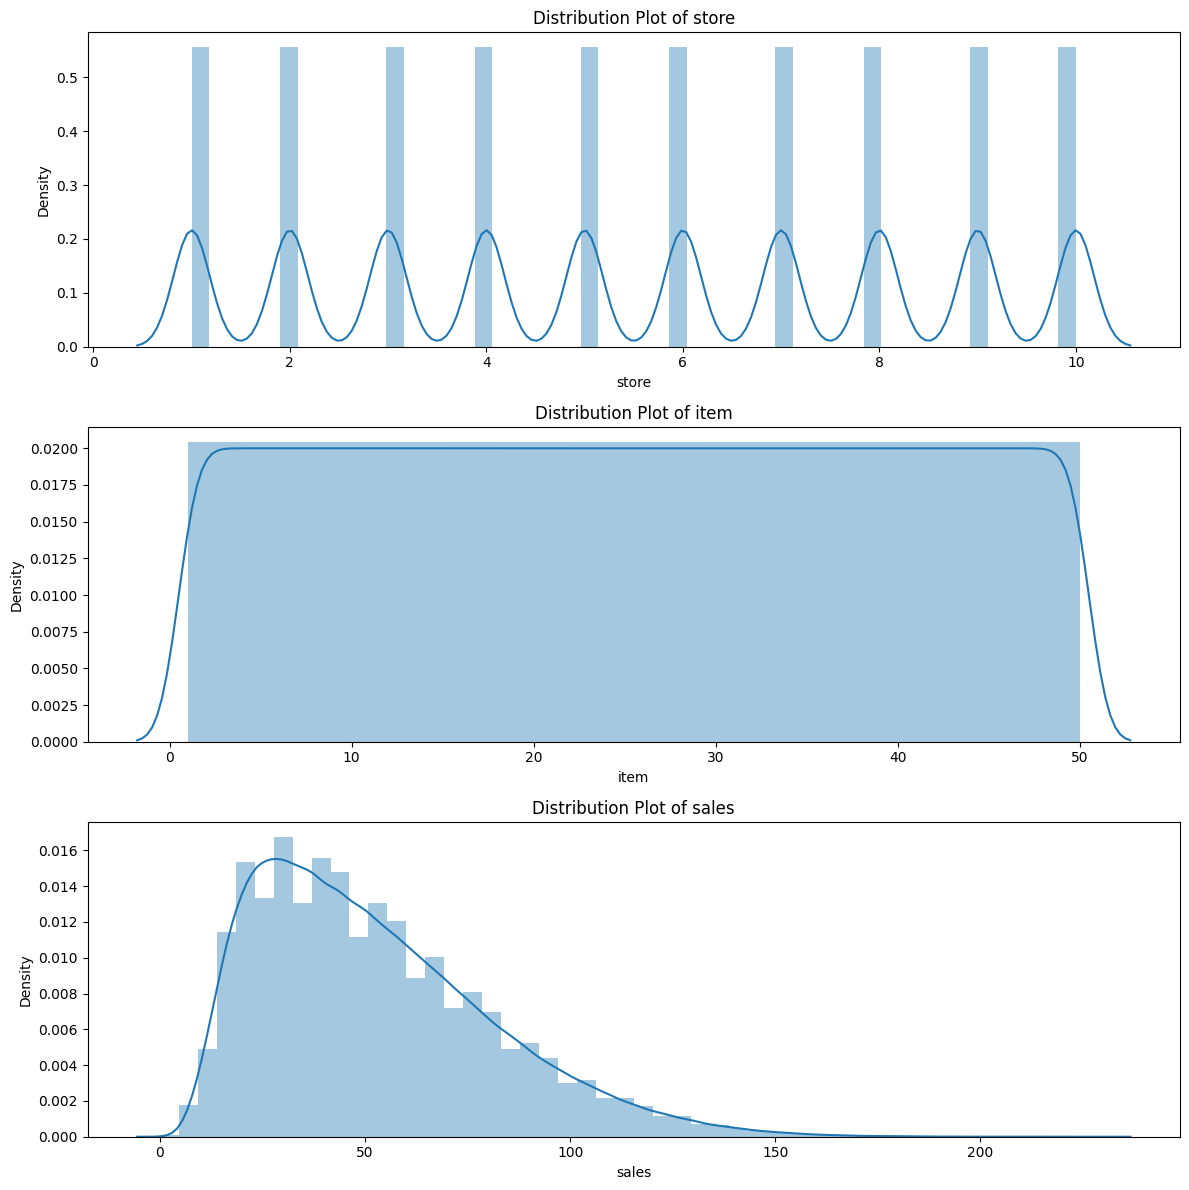

In [19]:
plot_charts_grid_single_feature(df.select_dtypes(include=['int64', 'float64']), my_distplot)

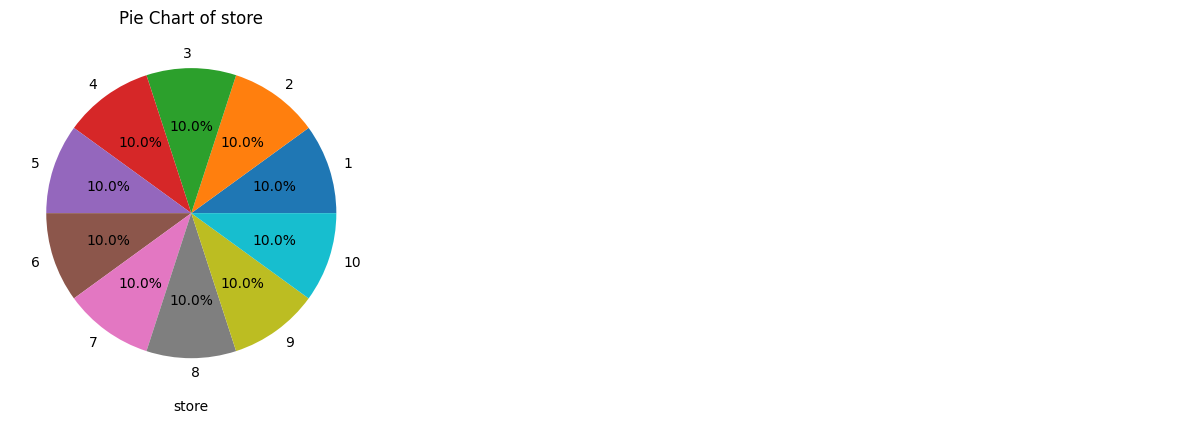

In [20]:
plot_charts_grid_single_feature(df[categorical_columns], my_pie_chart, size=(4, 4), n_col=3)

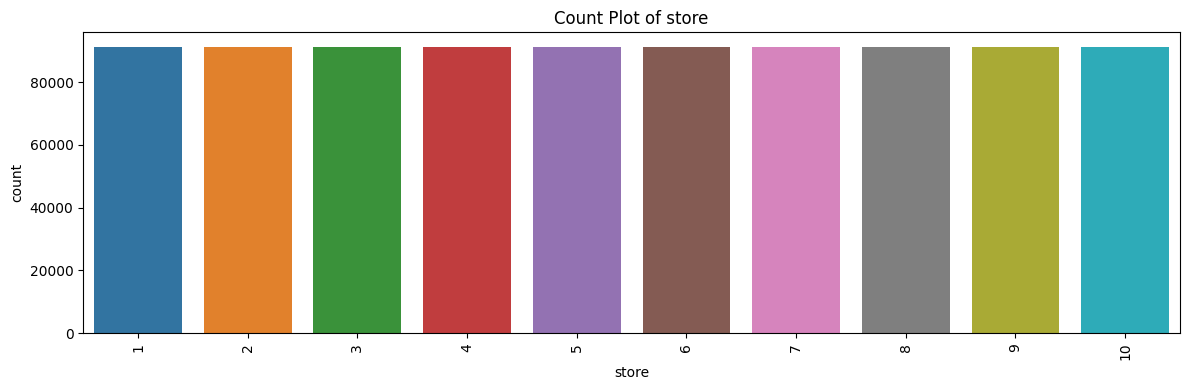

In [21]:
plot_charts_grid_single_feature(df[categorical_columns], my_countplot)

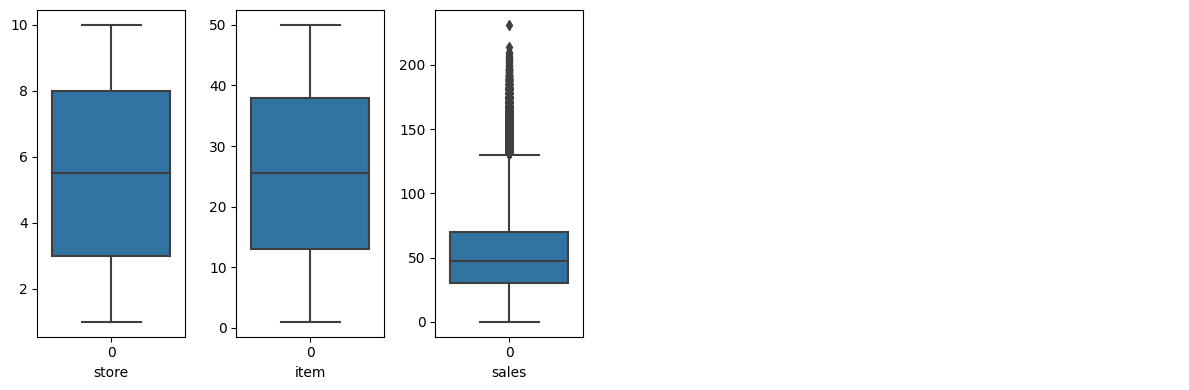

In [22]:
plot_charts_grid_single_feature(df.select_dtypes(include=['int64', 'float64']), my_boxplot, size=(2, 4), n_col=6)

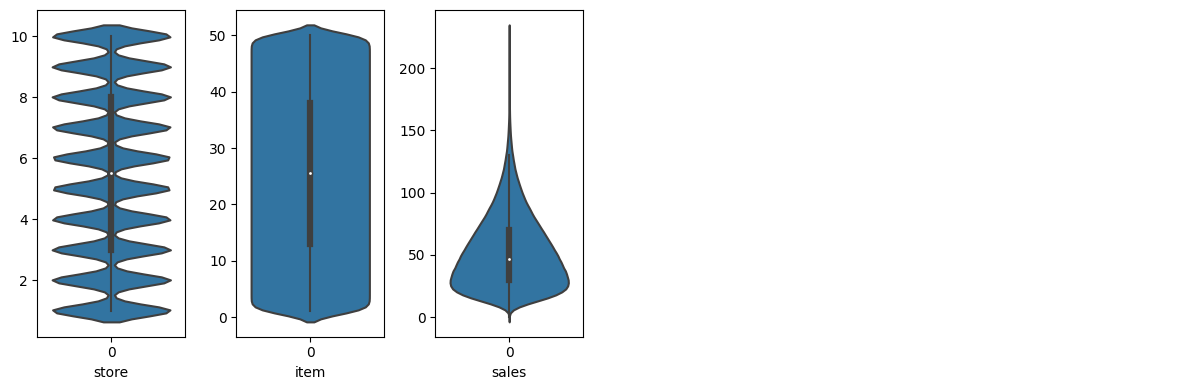

In [23]:
plot_charts_grid_single_feature(df.select_dtypes(include=['int64', 'float64']), my_violinplot, size=(2, 4), n_col=6)

In [24]:
def plot_charts_grid_multiple_feature(df, columns, plot_func, y_col, size=(12, 4), n_col=1):
    if len(columns) == 0:
        return
    n_rows = (len(columns) + n_col-1) // n_col
    fig, axes = plt.subplots(n_rows, n_col, figsize=(size[0]*n_col, size[1]*n_rows))
    if len(columns) == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, label in enumerate(columns):
        plot_func(x=label, y=y_col, ax=axes[i], data=df)
        axes[i].set_xlabel(label)

    for j in range(i+1, n_rows*n_col):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

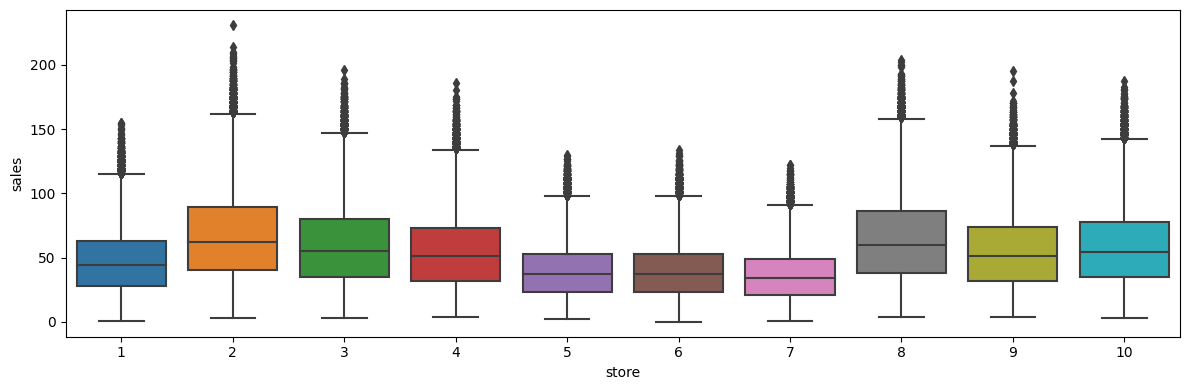

In [25]:
plot_charts_grid_multiple_feature(df, categorical_columns, sns.boxplot, y_col='sales')

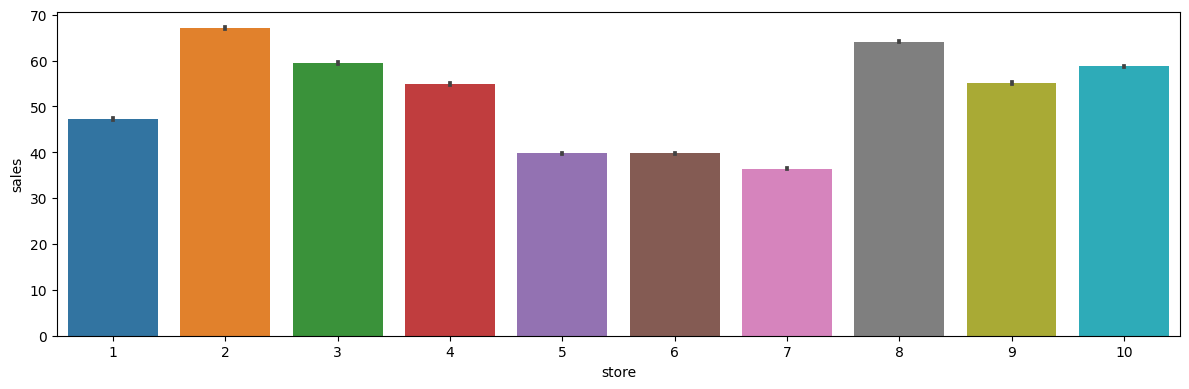

In [26]:
plot_charts_grid_multiple_feature(df, categorical_columns, sns.barplot, y_col='sales')

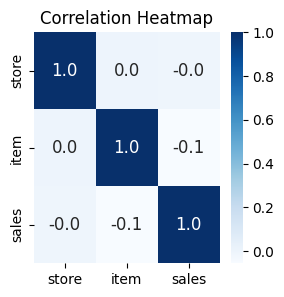

In [27]:
n_numeric_cols = len(df.select_dtypes(include=['int64', 'float64']).columns) // 3 * 2
my_heatmap(df.select_dtypes(include=['int64', 'float64']), size=(n_numeric_cols+1, n_numeric_cols+1))

# Feature Engineering and Transformation

In [28]:
df.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [29]:
def add_columns(df):
    df["date"]       = pd.to_datetime(df["date"])
    df["year"]       = df["date"].dt.year
    df["month"]      = df["date"].dt.month
    df["day"]        = df["date"].dt.day
    df["weekday"]    = df["date"].dt.weekday
    df["weekofyear"] = df["date"].dt.isocalendar().week
    
    df["is_weekend"]     = df["weekday"].apply(lambda x: 1 if x >= 5 else 0)
    df["is_month_end"]   = df["date"].dt.is_month_end.astype(int)
    df["is_month_start"] = df["date"].dt.is_month_start.astype(int)

    df["store_item"]      = df["store"].astype(str) + "_" + df["item"].astype(str)
    start_date            = df["date"].min()
    df["days_from_start"] = (df["date"] - start_date).dt.days

In [30]:
add_columns(df)
add_columns(test)

In [31]:
df["lag_7"]  = df.groupby(["store", "item"])["sales"].shift(7)
df["lag_30"] = df.groupby(["store", "item"])["sales"].shift(30)

In [32]:
additional_columns = ['year', 'month', 'day', 'weekday', 'weekofyear', 'is_weekend', 'is_month_end', 'is_month_start', 'lag_7', 'lag_30']

In [33]:
categorical_columns = [col for col in df.columns if len(df[col].unique()) < 50]

In [34]:
df.head(10)

,date,store,item,sales,year,month,day,weekday,weekofyear,is_weekend,is_month_end,is_month_start,store_item,days_from_start,lag_7,lag_30
0,2013-01-01,1,1,13,2013,1,1,1,1,0,0,1,1_1,0,NaN,NaN
1,2013-01-02,1,1,11,2013,1,2,2,1,0,0,0,1_1,1,NaN,NaN
2,2013-01-03,1,1,14,2013,1,3,3,1,0,0,0,1_1,2,NaN,NaN
3,2013-01-04,1,1,13,2013,1,4,4,1,0,0,0,1_1,3,NaN,NaN
4,2013-01-05,1,1,10,2013,1,5,5,1,1,0,0,1_1,4,NaN,NaN
5,2013-01-06,1,1,12,2013,1,6,6,1,1,0,0,1_1,5,NaN,NaN
6,2013-01-07,1,1,10,2013,1,7,0,2,0,0,0,1_1,6,NaN,NaN
7,2013-01-08,1,1,9,2013,1,8,1,2,0,0,0,1_1,7,13.0,NaN
8,2013-01-09,1,1,12,2013,1,9,2,2,0,0,0,1_1,8,11.0,NaN
9,2013-01-10,1,1,9,2013,1,10,3,2,0,0,0,1_1,9,14.0,NaN


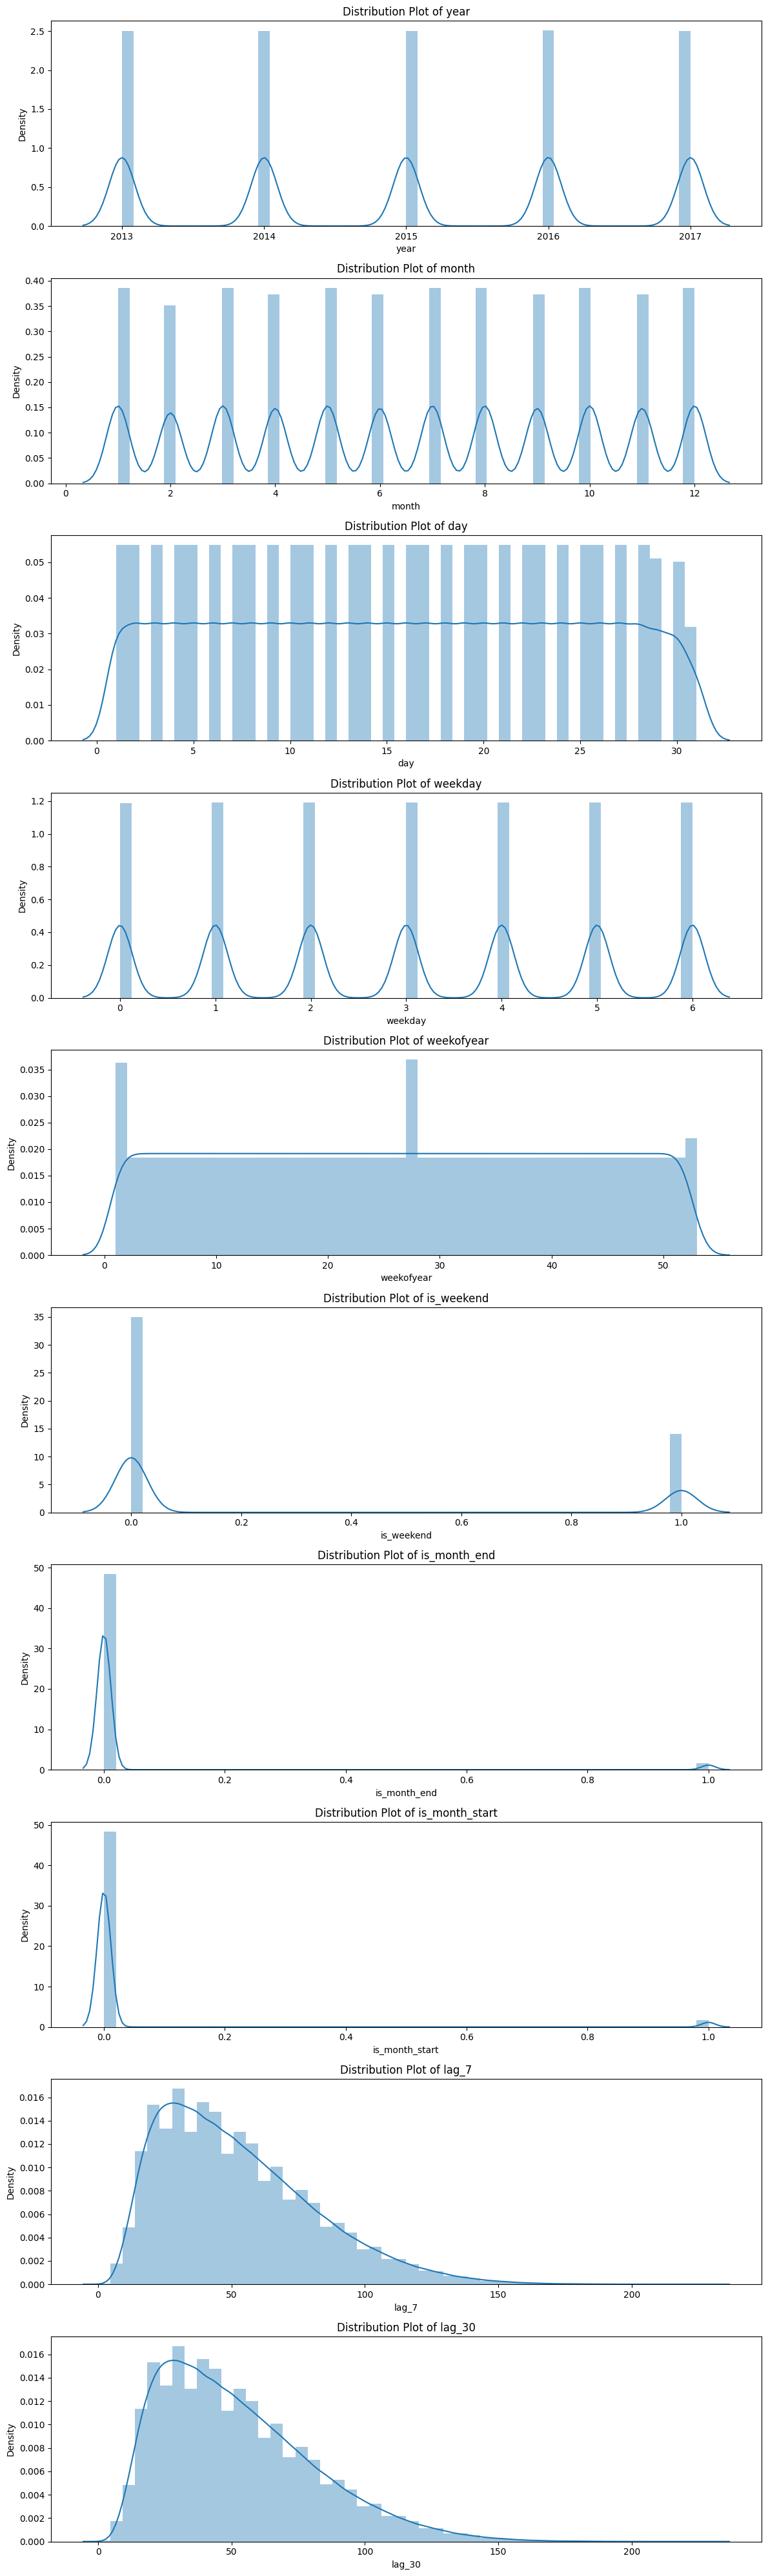

In [35]:
plot_charts_grid_single_feature(df[additional_columns], my_distplot)

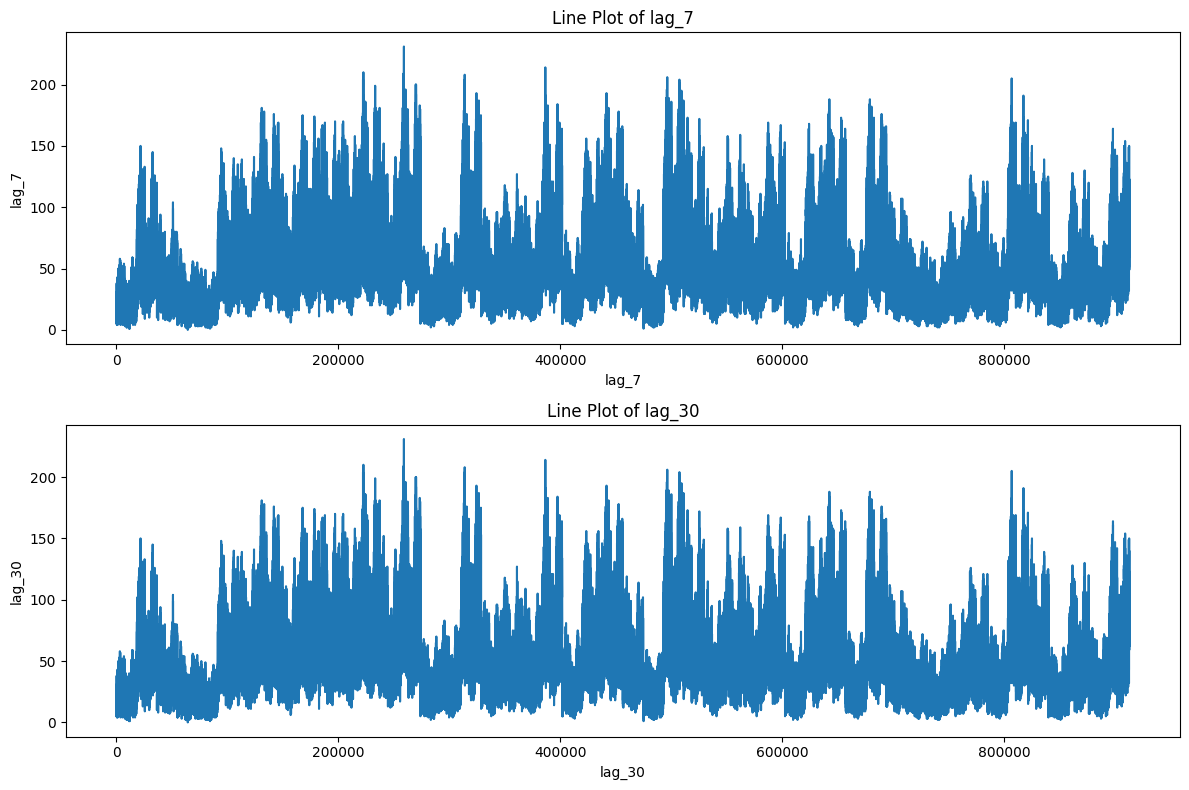

In [36]:
plot_charts_grid_single_feature(df[['lag_7', 'lag_30']], my_lineplot)

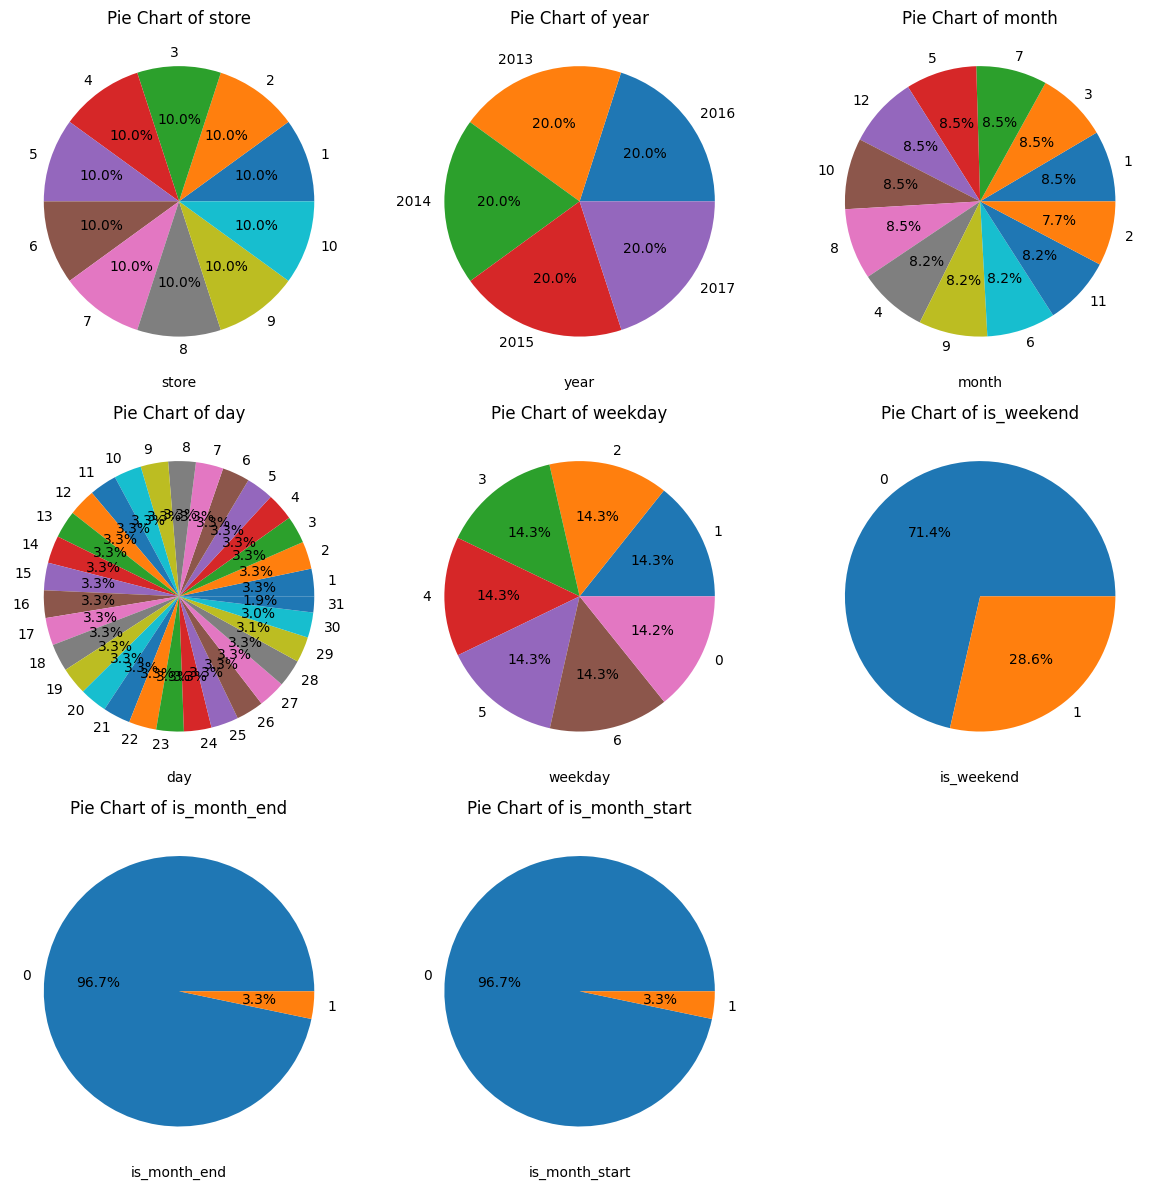

In [37]:
plot_charts_grid_single_feature(df[categorical_columns], my_pie_chart, size=(4, 4), n_col=3)

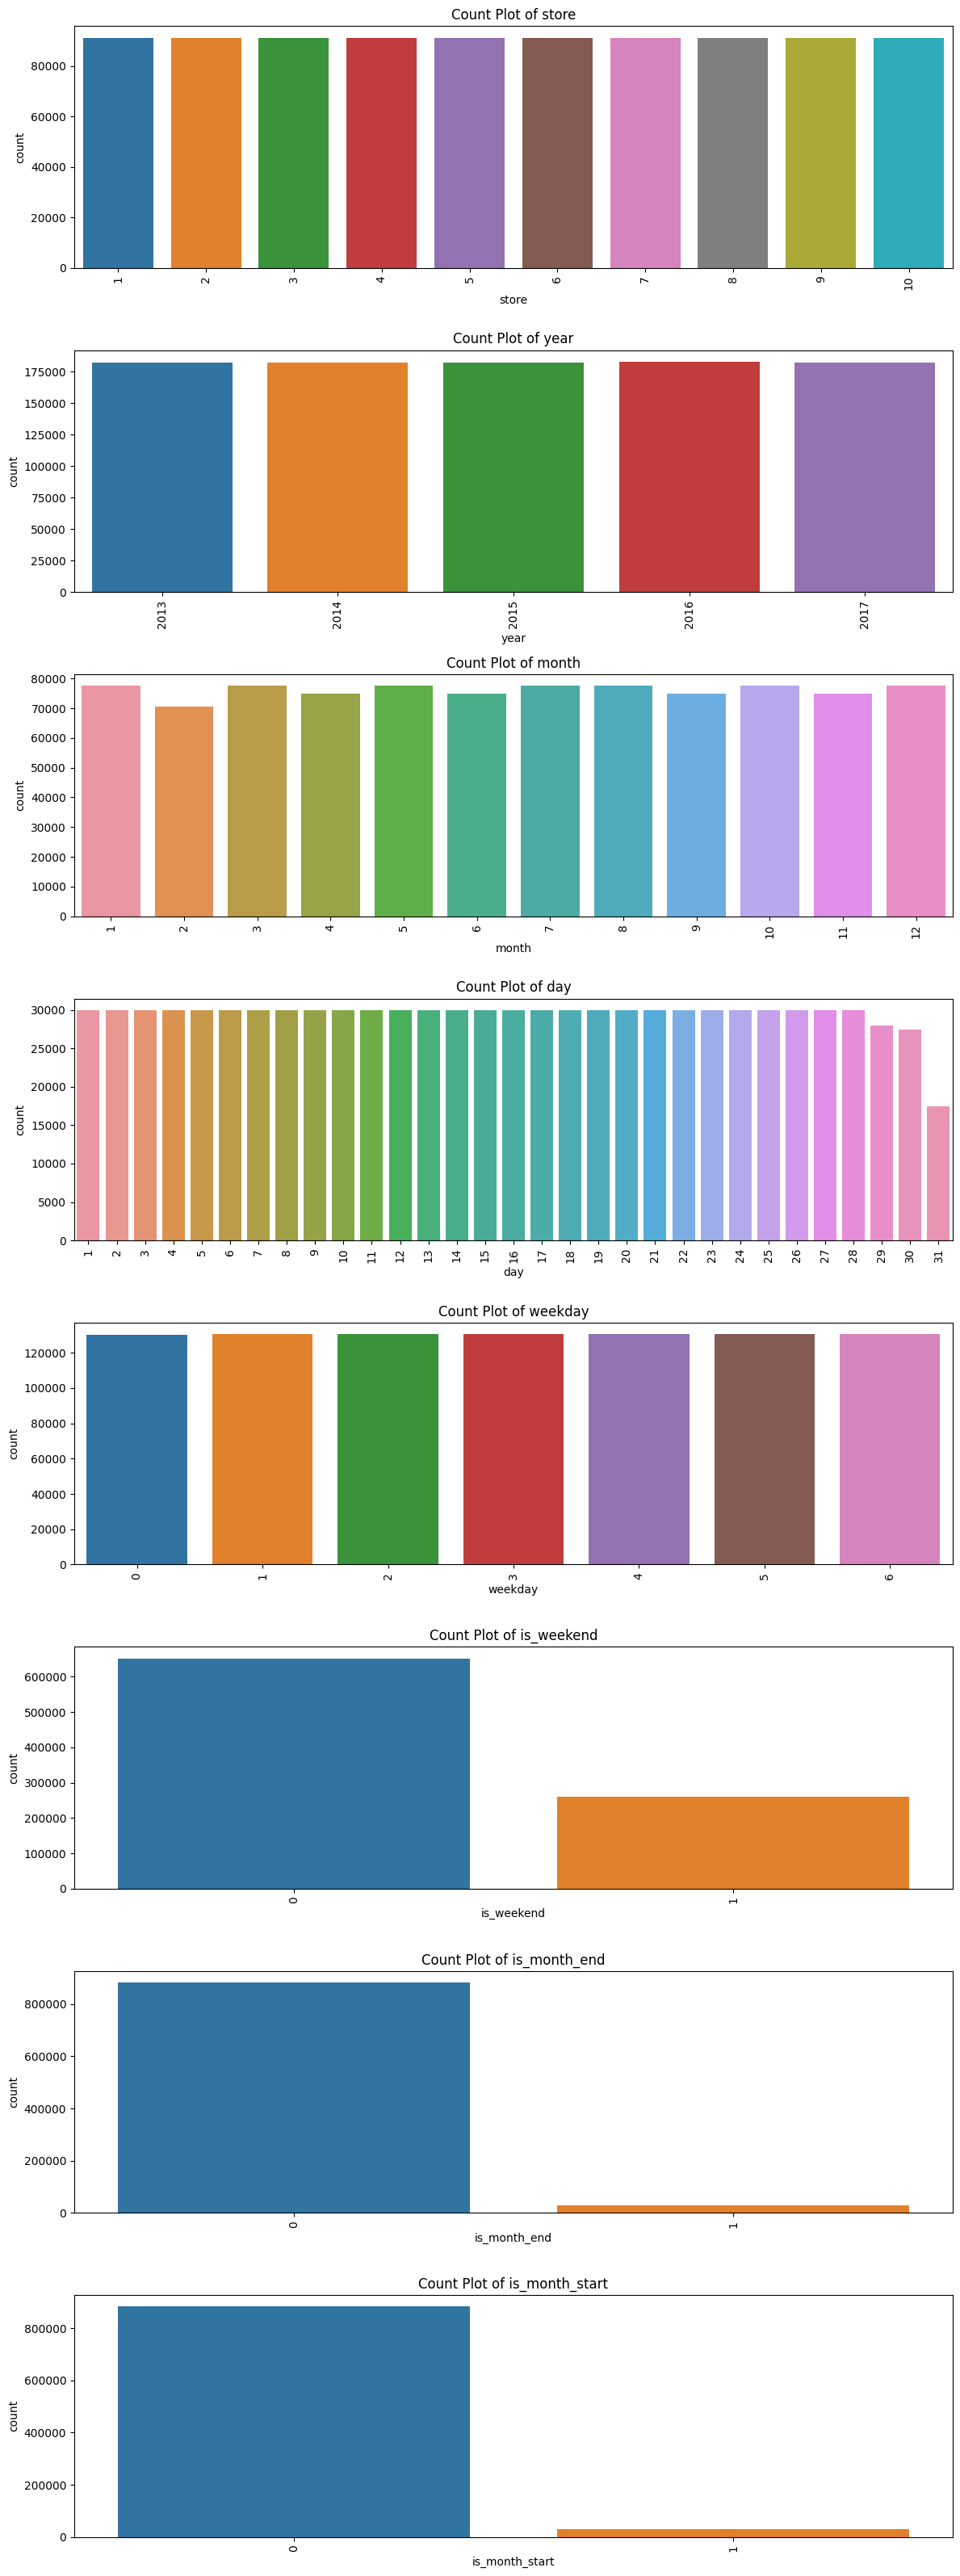

In [38]:
plot_charts_grid_single_feature(df[categorical_columns], my_countplot)

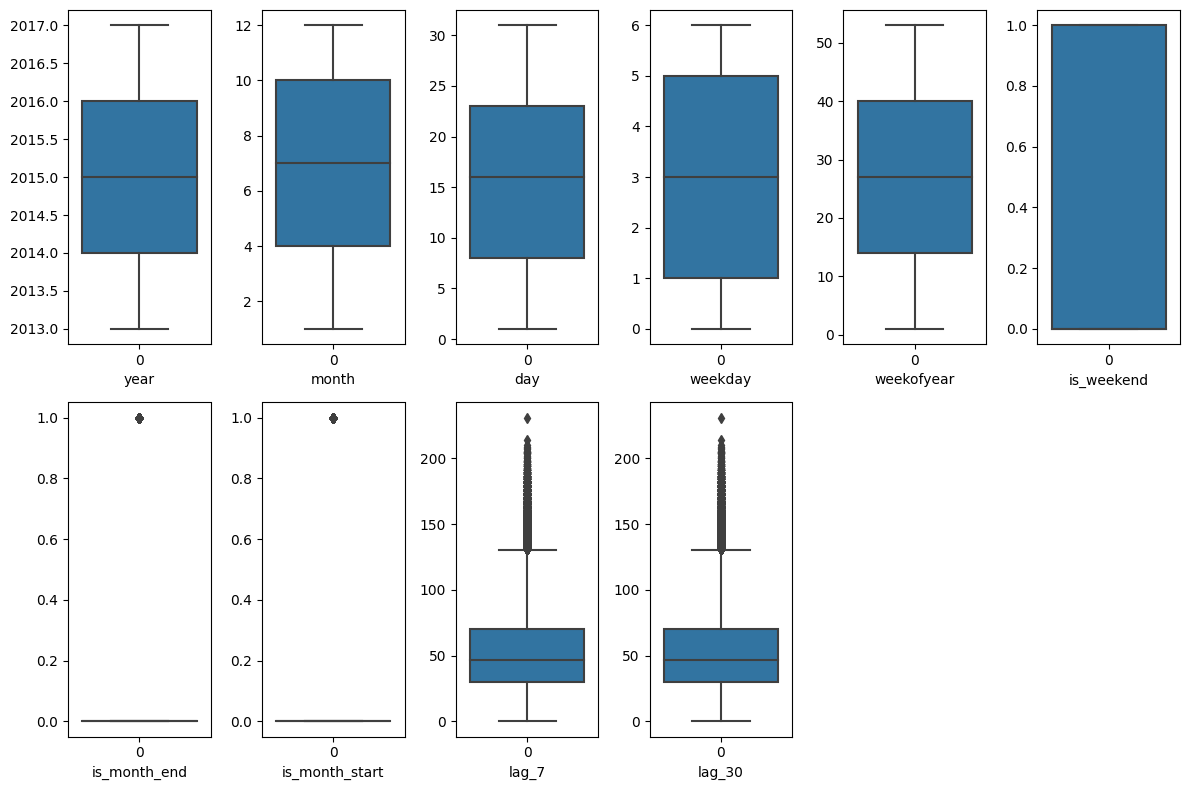

In [39]:
plot_charts_grid_single_feature(df[additional_columns], my_boxplot, size=(2, 4), n_col=6)

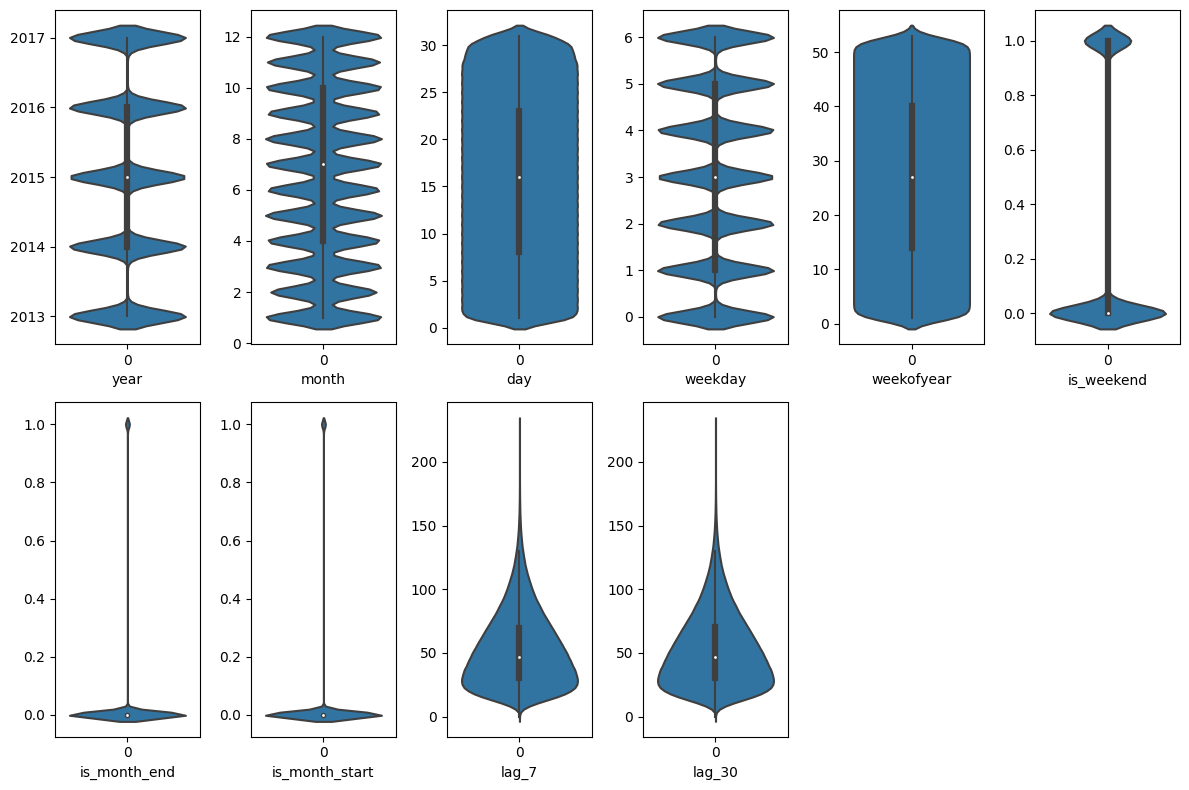

In [40]:
plot_charts_grid_single_feature(df[additional_columns], my_violinplot, size=(2, 4), n_col=6)

In [41]:
store_sales = df.groupby("store")["sales"].sum()
item_sales  = df.groupby("item")["sales"].sum()

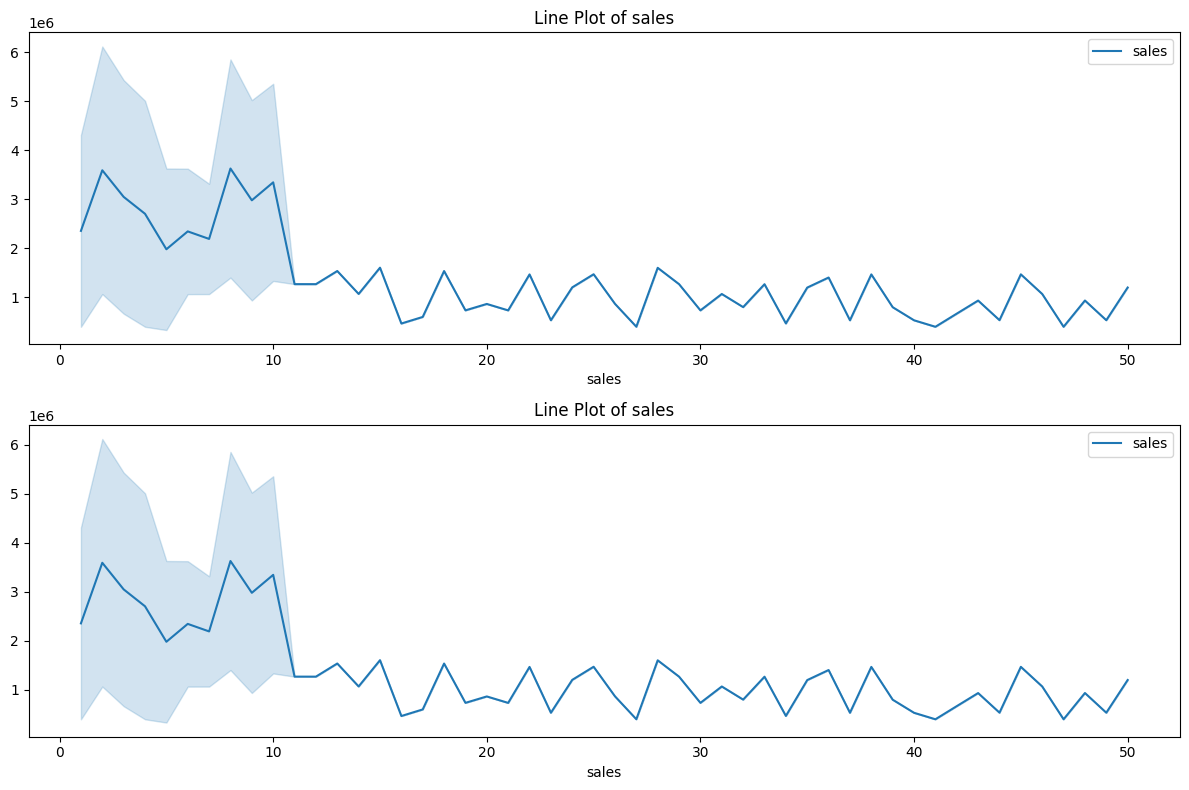

In [42]:
plot_charts_grid_single_feature(pd.concat([store_sales, item_sales], axis=1), my_lineplot)

# Outliers Detection

In [43]:
float_features = df.select_dtypes(include=['int64', 'float64']).columns

In [44]:
df[float_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   store            913000 non-null  int64  
 1   item             913000 non-null  int64  
 2   sales            913000 non-null  int64  
 3   is_weekend       913000 non-null  int64  
 4   is_month_end     913000 non-null  int64  
 5   is_month_start   913000 non-null  int64  
 6   days_from_start  913000 non-null  int64  
 7   lag_7            909500 non-null  float64
 8   lag_30           898000 non-null  float64
dtypes: float64(2), int64(7)
memory usage: 62.7 MB


In [45]:
def plot_column_with_outlier_effect(df, plot_func, outliers_indices, x_col, y_col):
    fig, ax = plt.subplots(1, 2, figsize=(12*2, 4))
    ax[0].set_title('Original Data')
    ax[1].set_title(f'Data without Outliers of {y_col}')
    plot_func(x=x_col, y=y_col, ax=ax[0], data=df)
    plot_func(x=x_col, y=y_col, ax=ax[1], data=df.drop(outliers_indices))
    plt.tight_layout()
    plt.show()

In [46]:
def outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 = 1.5 * IQR
    return df.index[(df[col] < lower_bound) | (df[col] > upper_bound)]

In [47]:
def detect_outliers(df, col):
    outliers_indices = [item for item in outliers(df, col)]
    print(f'length of {col} outliers_indices: {len(outliers_indices)}')
    for cat_col in categorical_columns:
        plot_column_with_outlier_effect(df, sns.boxplot, outliers_indices, x_col=cat_col, y_col=col)
        plot_column_with_outlier_effect(df, sns.barplot, outliers_indices, x_col=cat_col, y_col=col)

length of sales outliers_indices: 308670


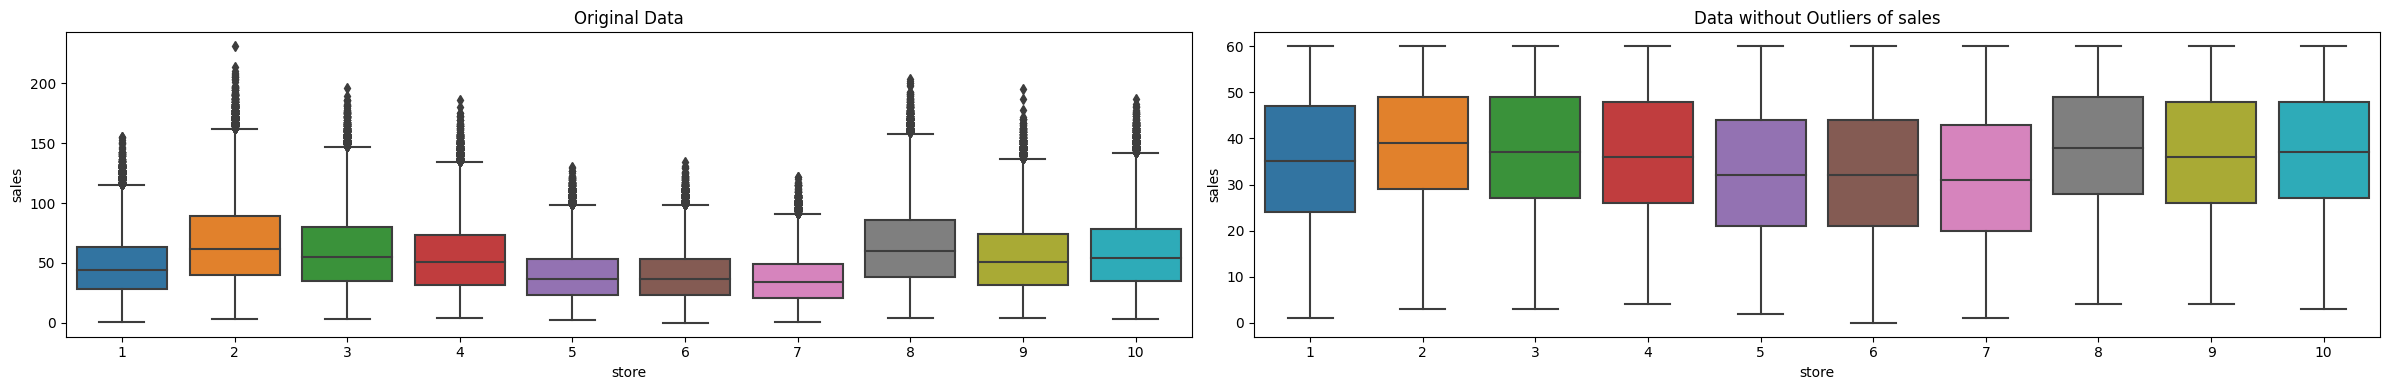

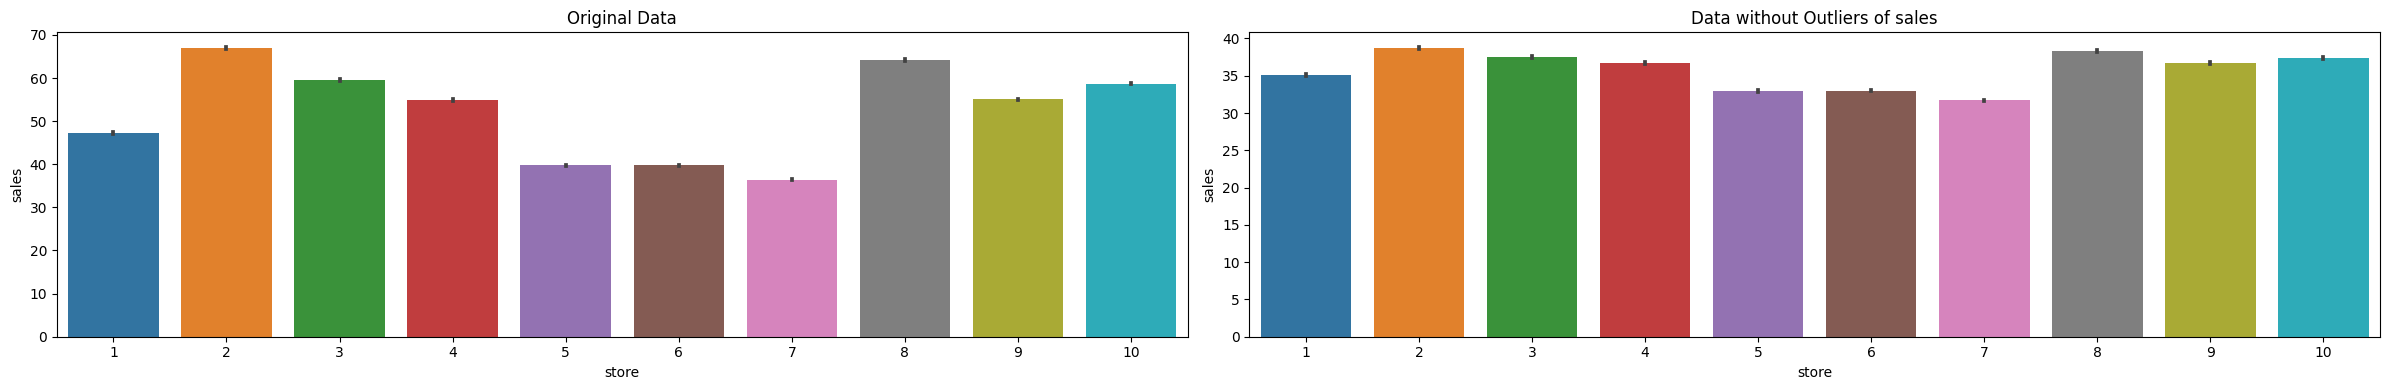

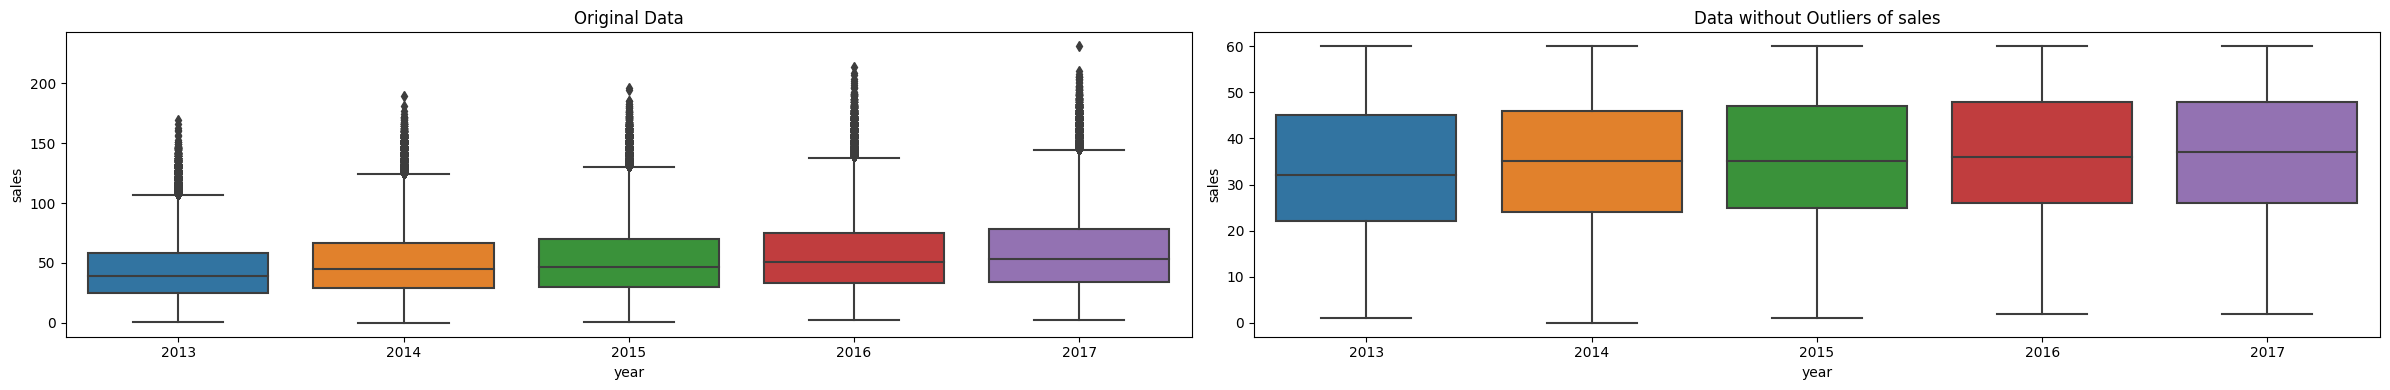

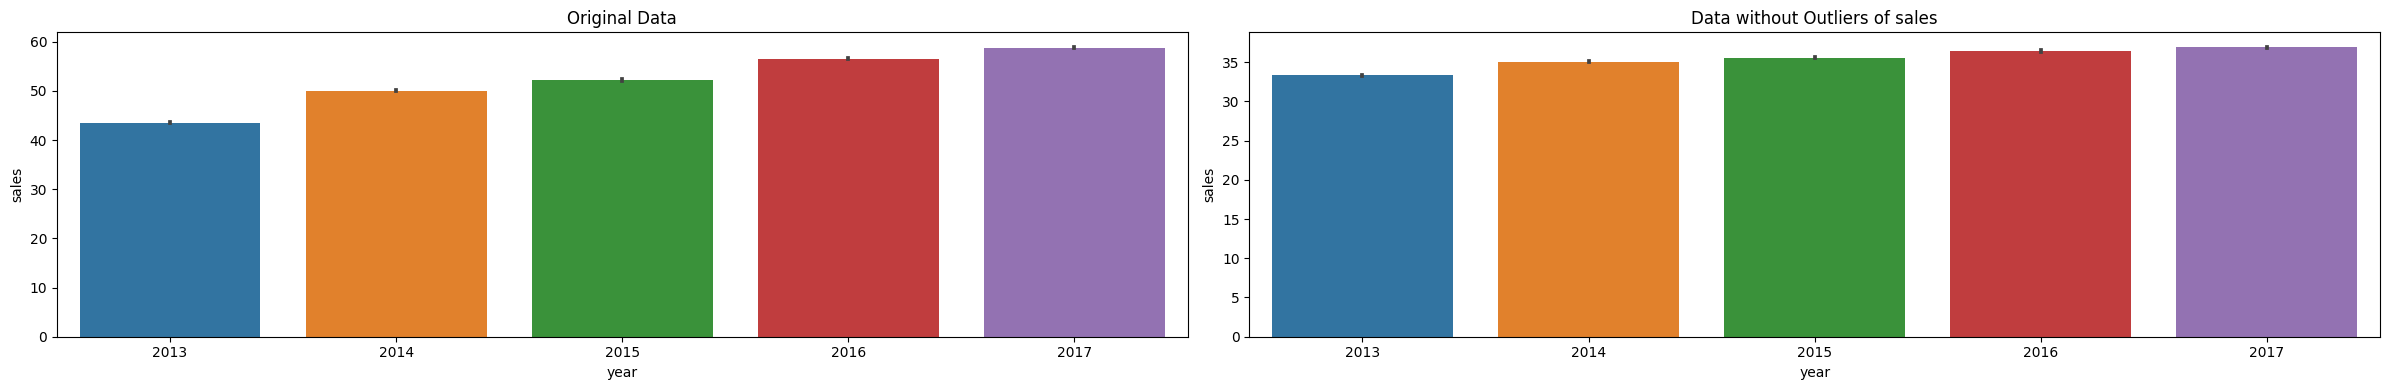

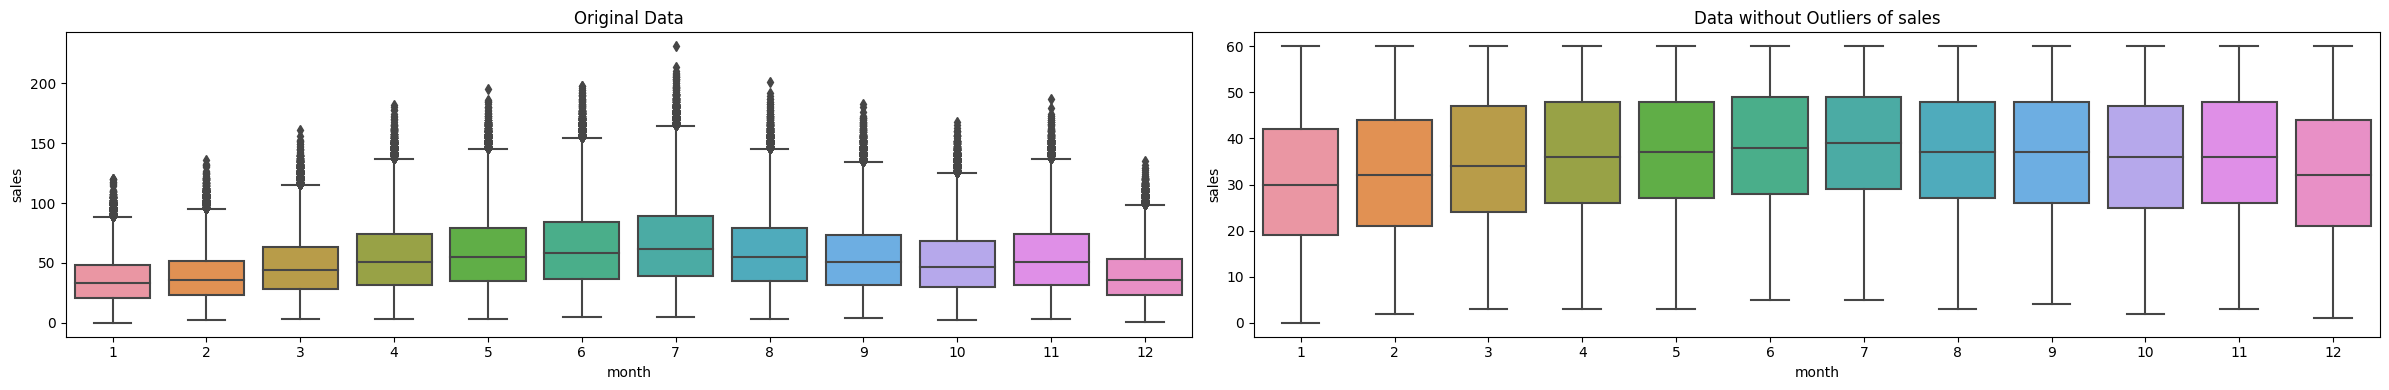

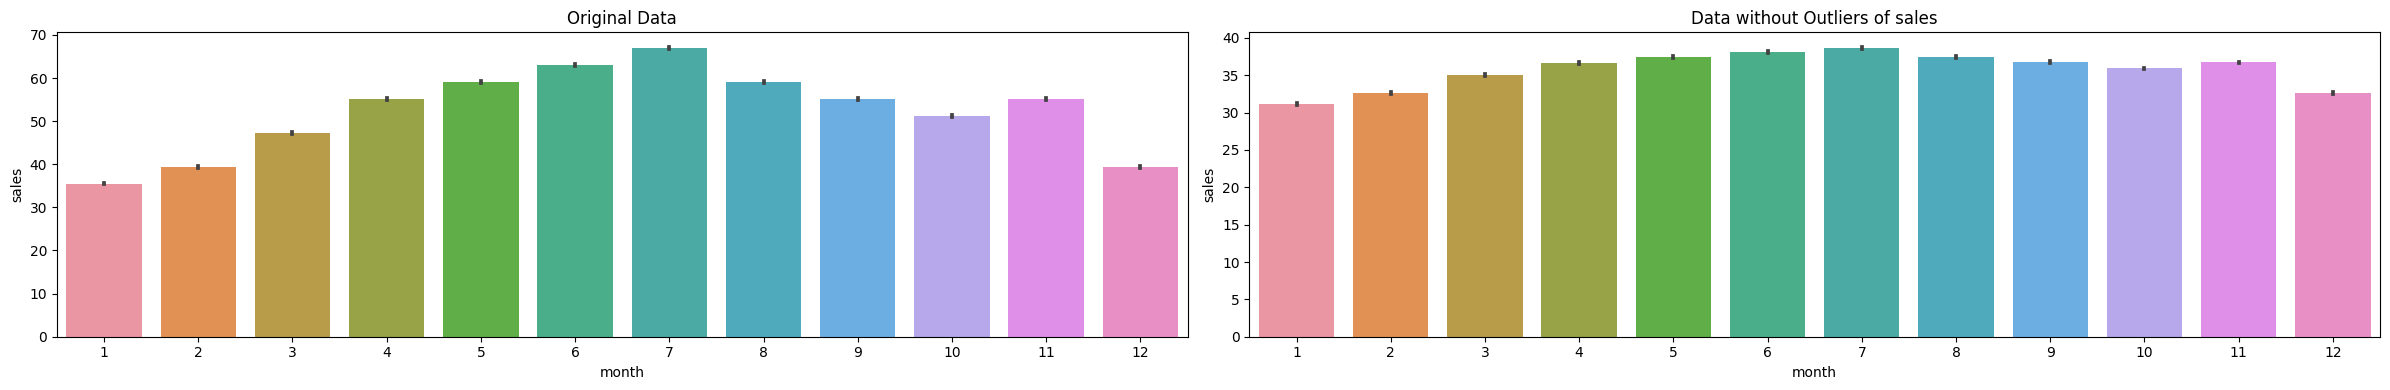

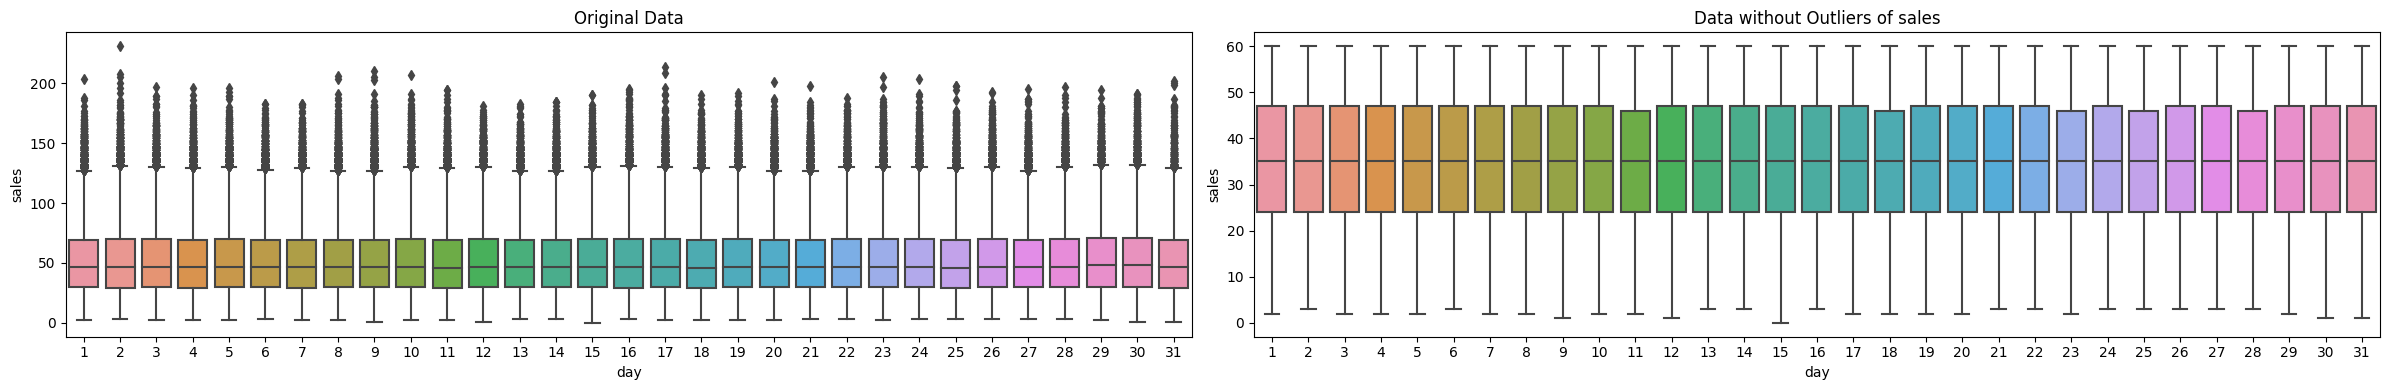

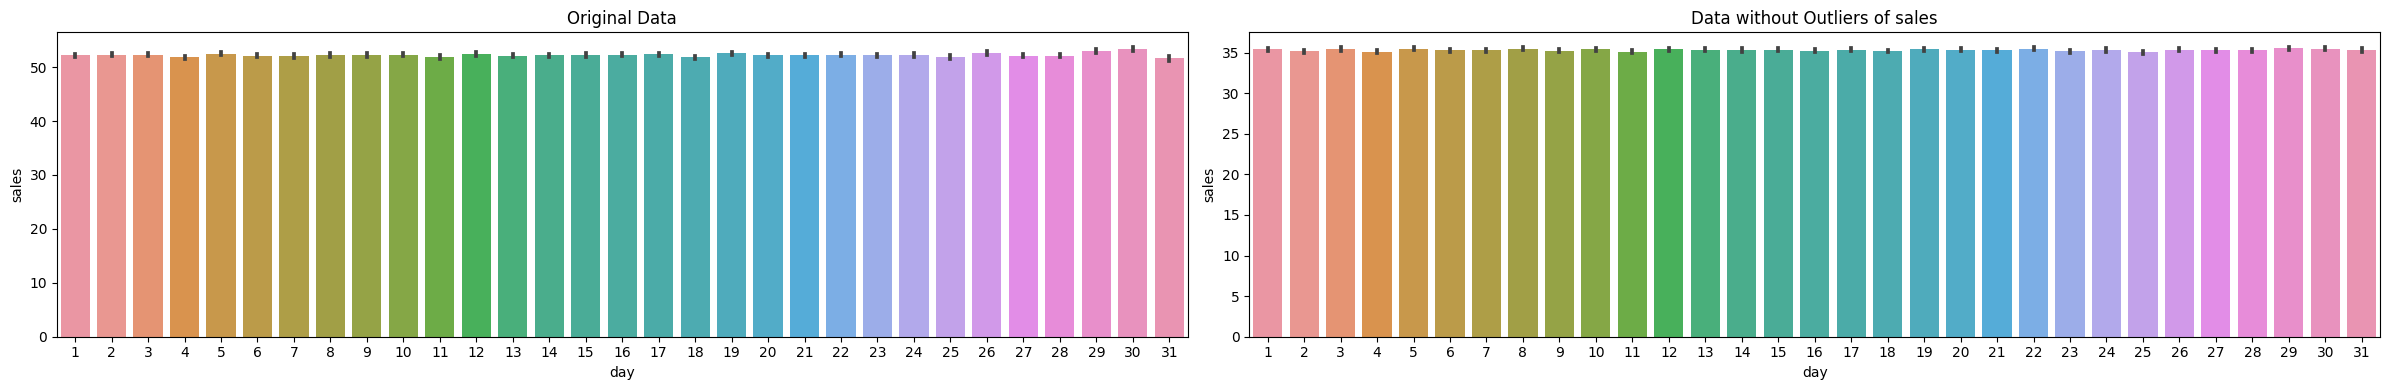

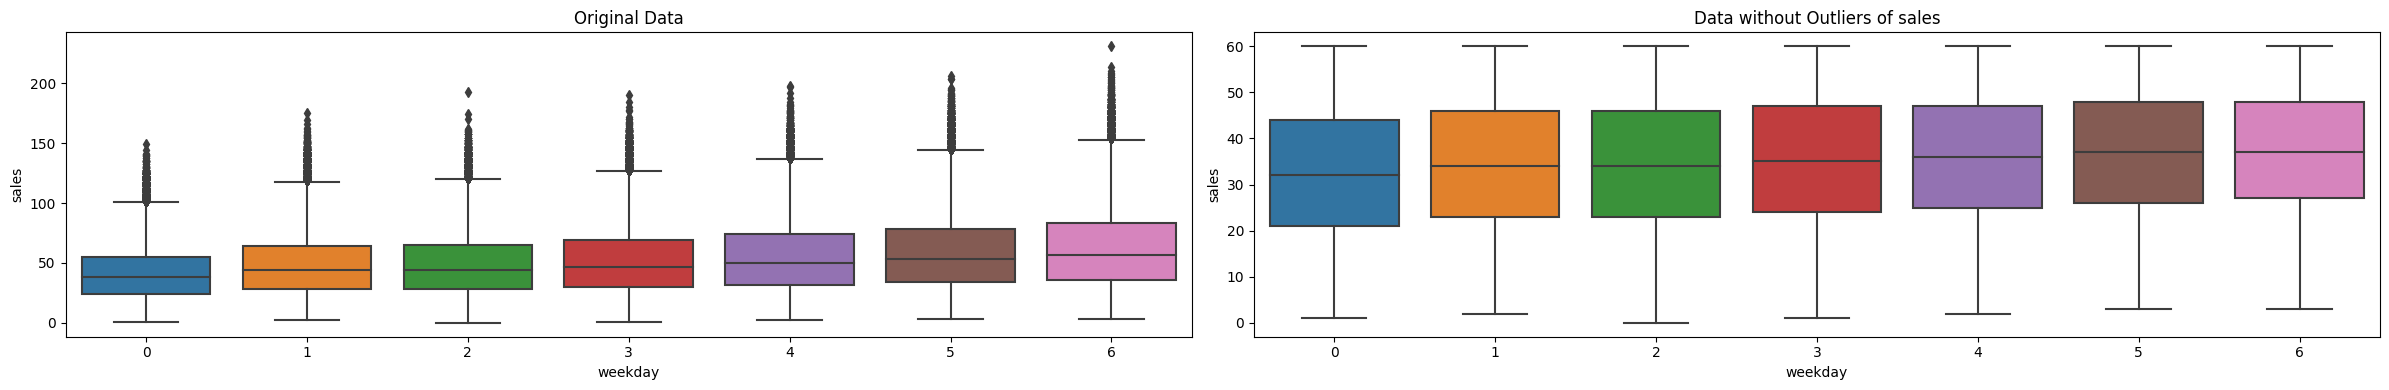

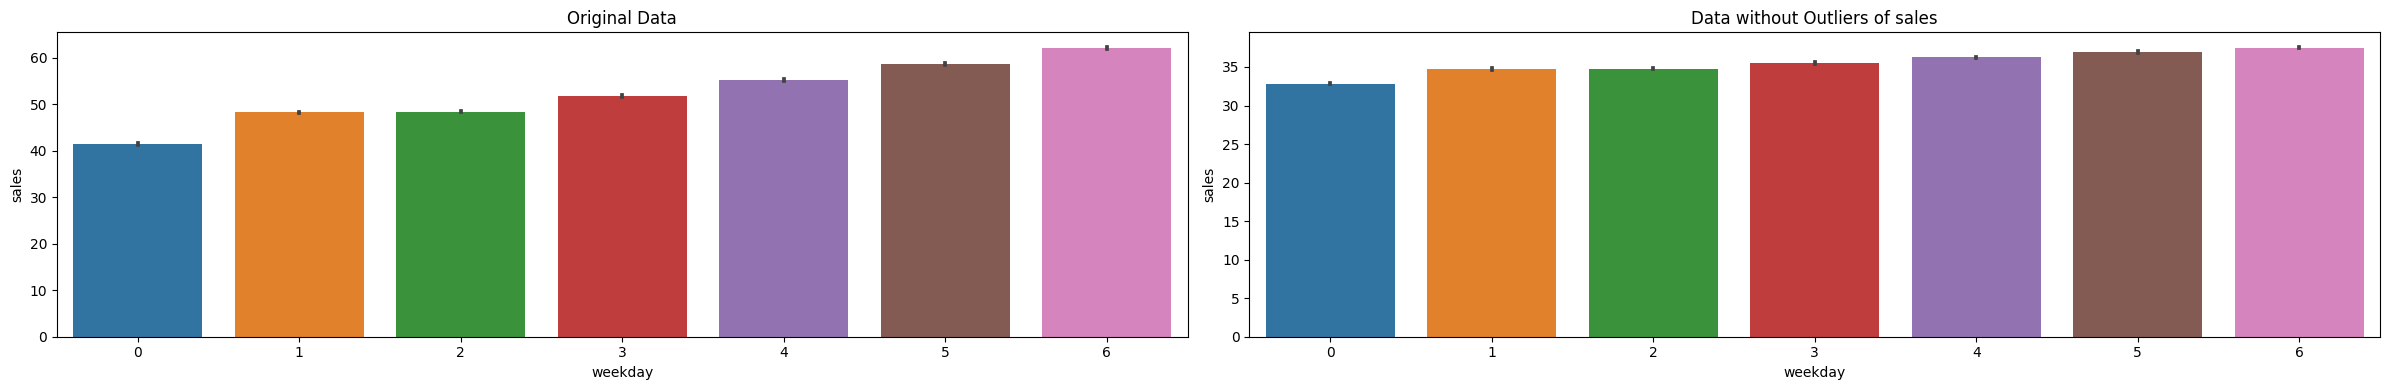

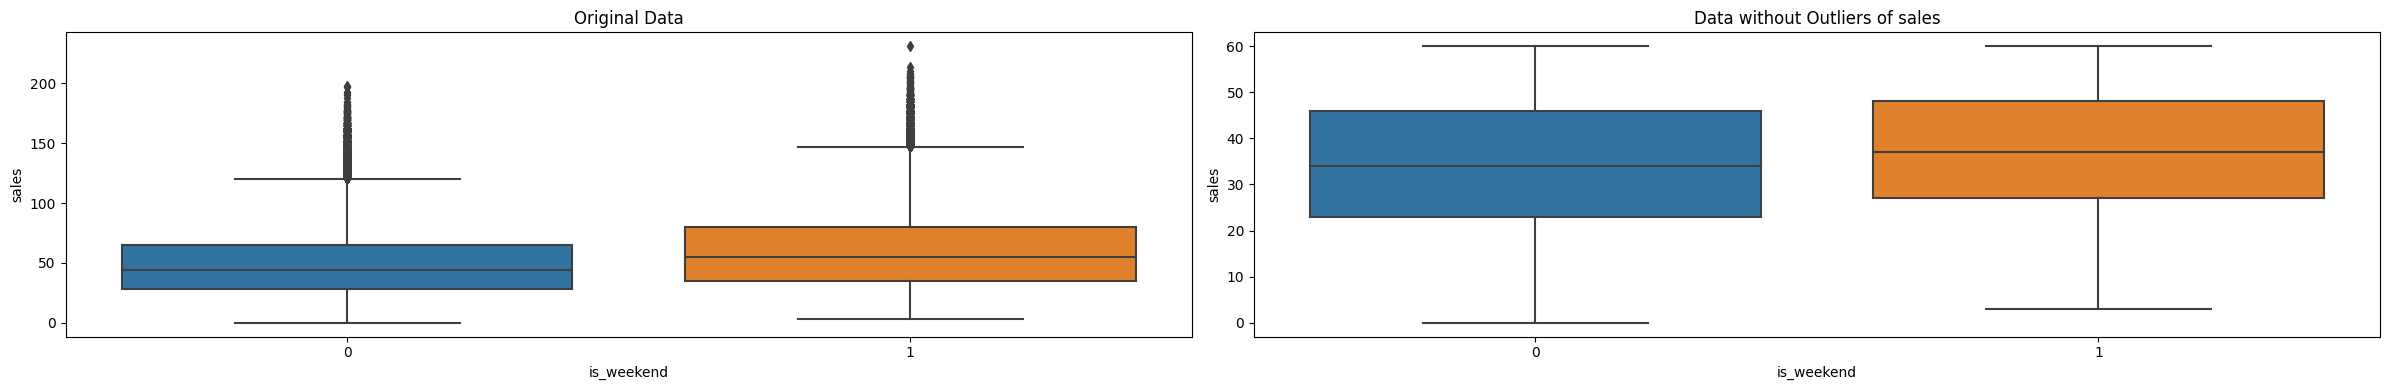

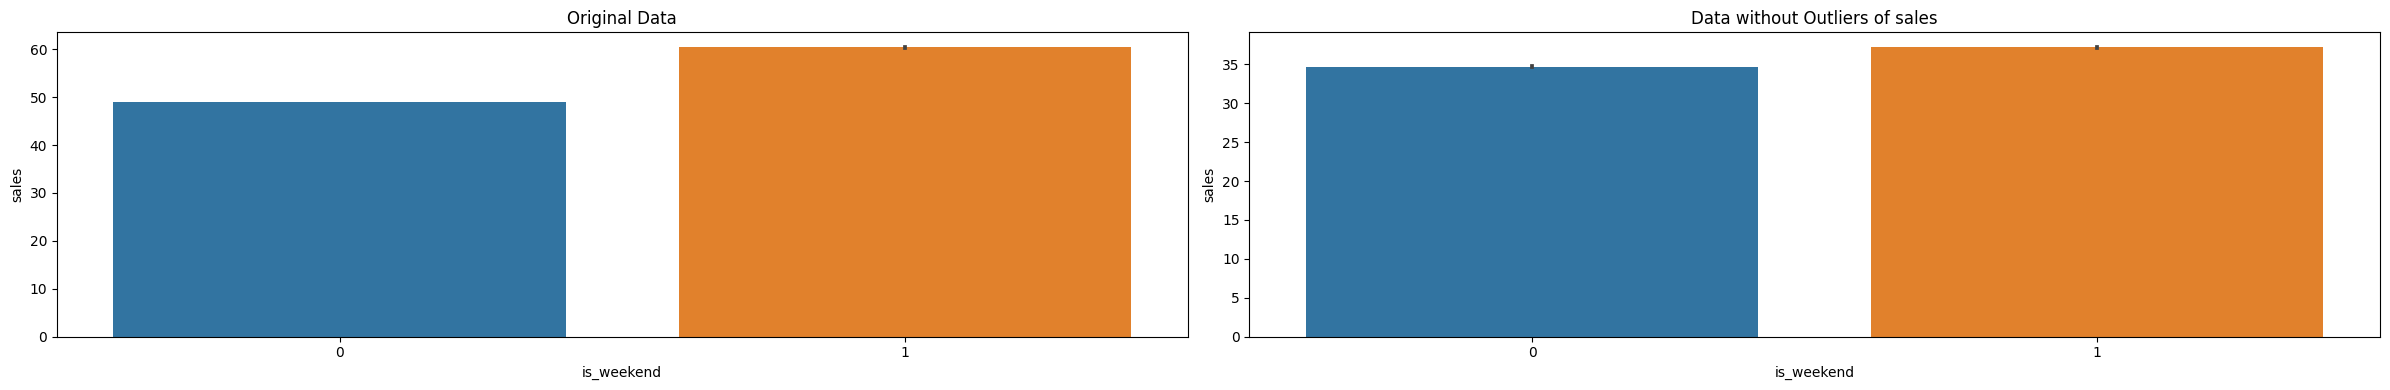

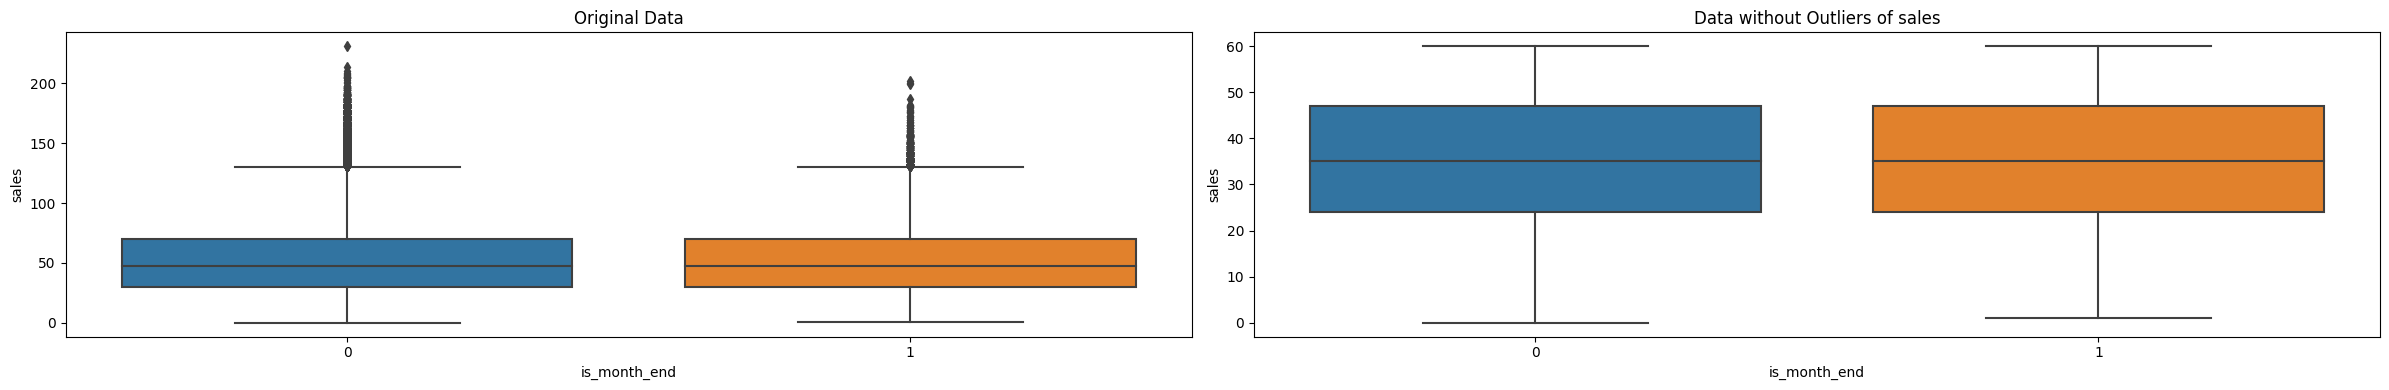

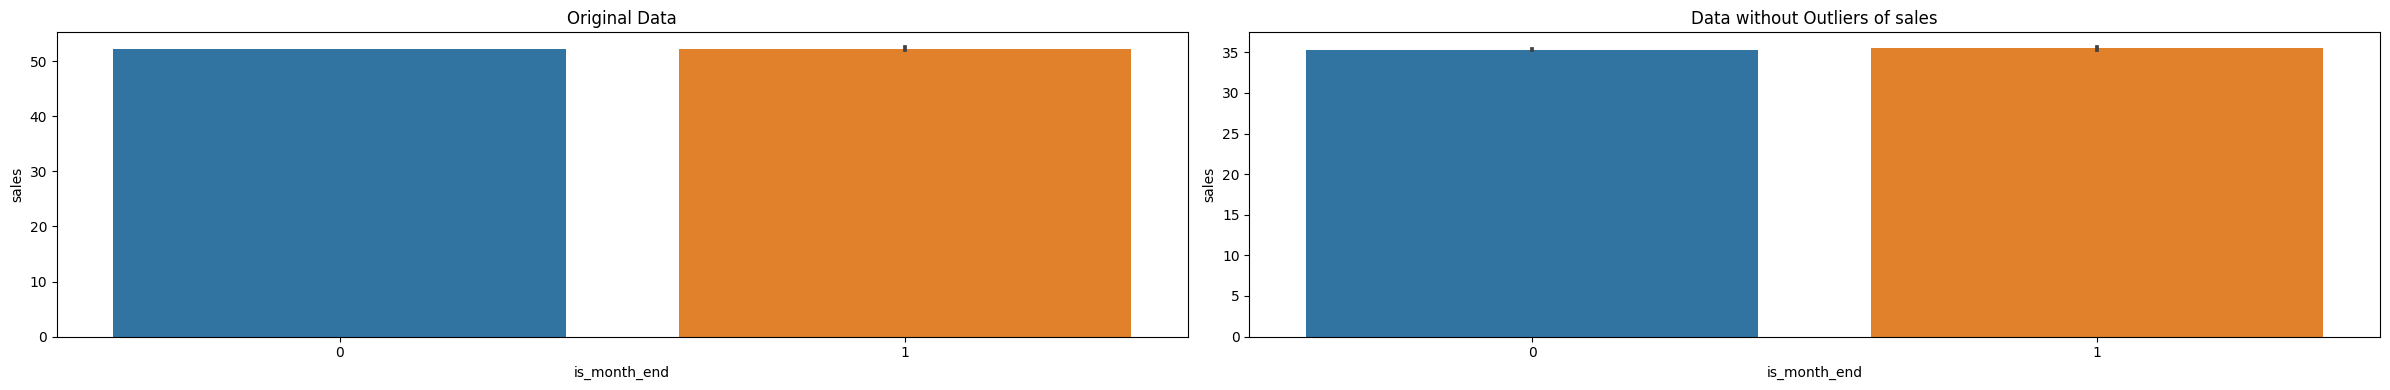

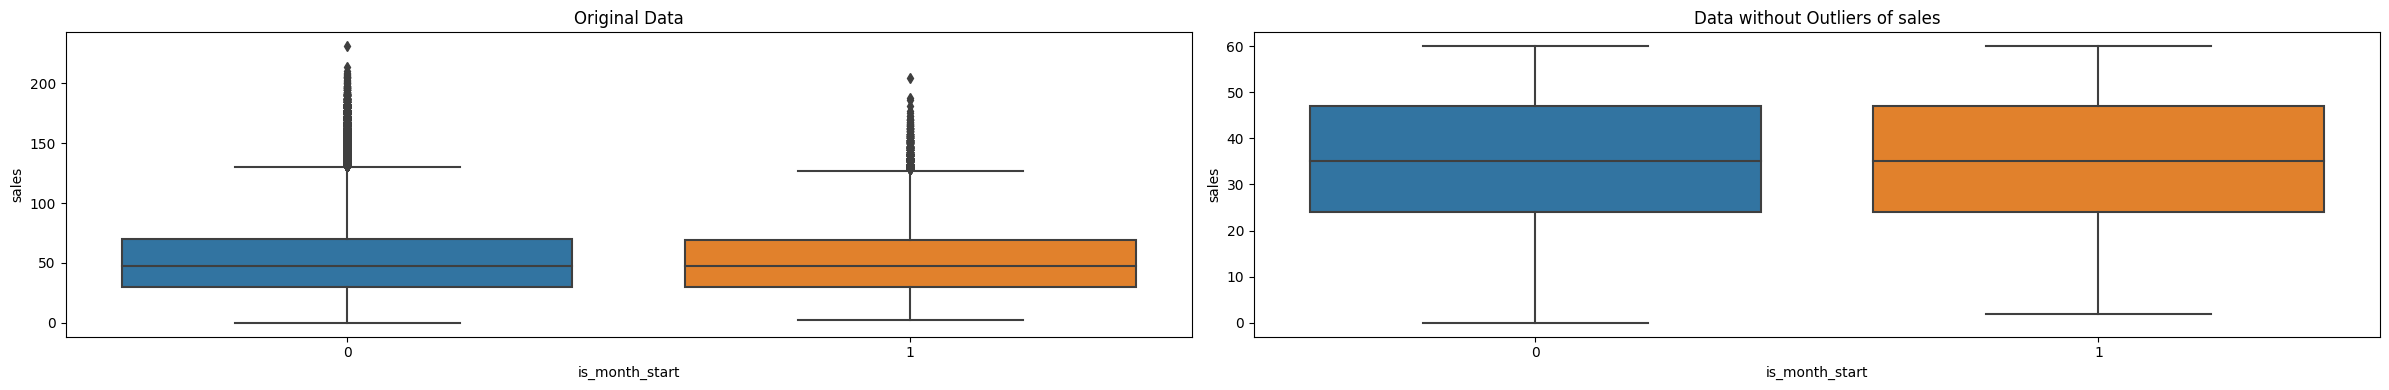

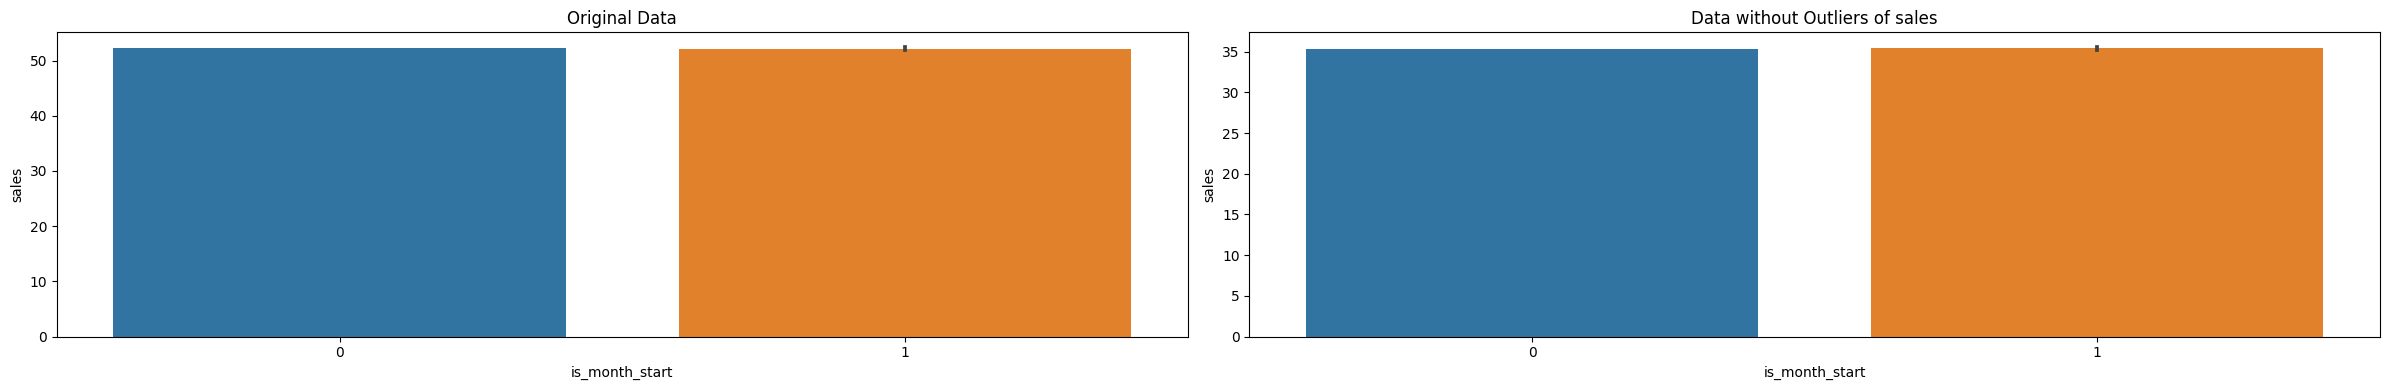

In [48]:
detect_outliers(df, 'sales')

# Single Feature Analysis

In [49]:
def plot_top_n(df, xlabel, ylabel, n=25, figsize=(12, 4)):
    plt.figure(figsize=figsize)
    sns.barplot(x=df.index, y=df)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    yminlim = df.min()
    ymaxlim = df.max()
    yrange = (ymaxlim - yminlim) * .05
    yminlim -= yrange
    ymaxlim += yrange
    plt.ylim(yminlim, ymaxlim)
    plt.title(f'Top {n} {xlabel} based on the {ylabel}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

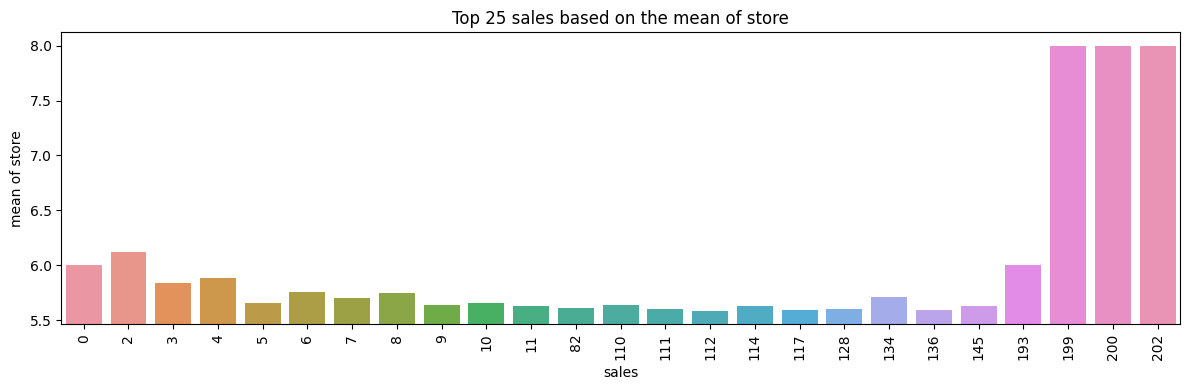

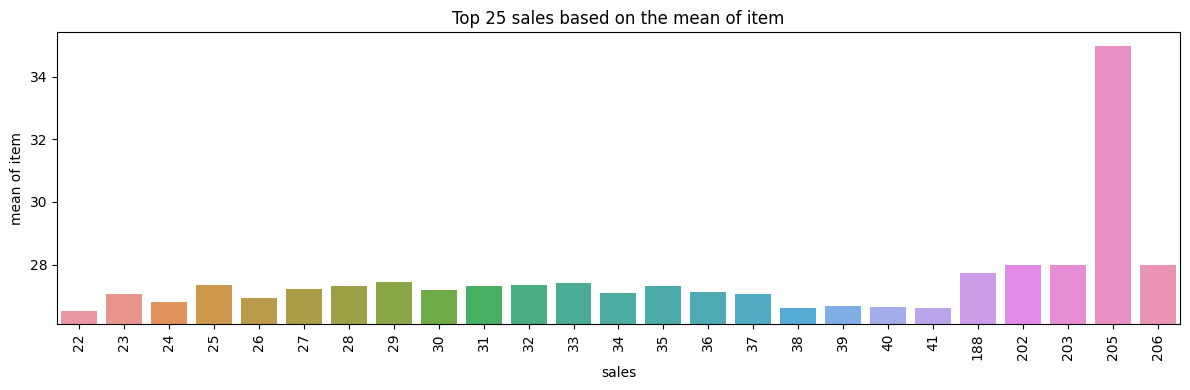

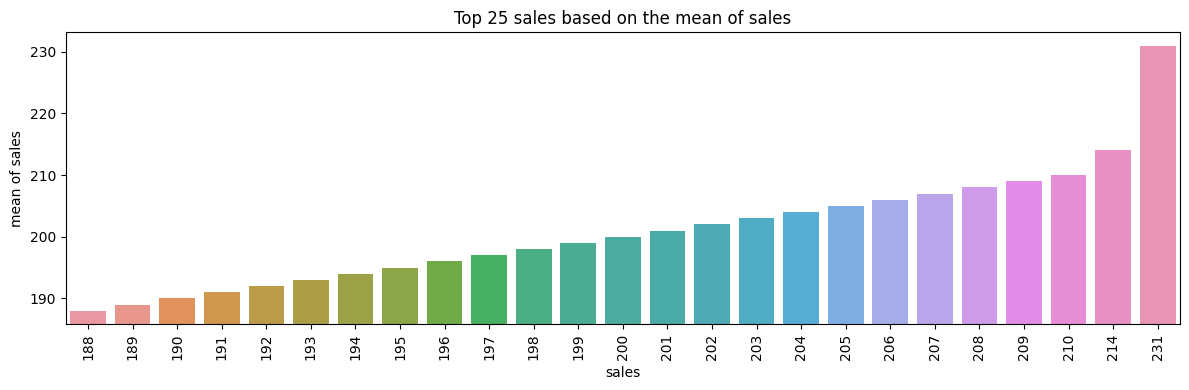

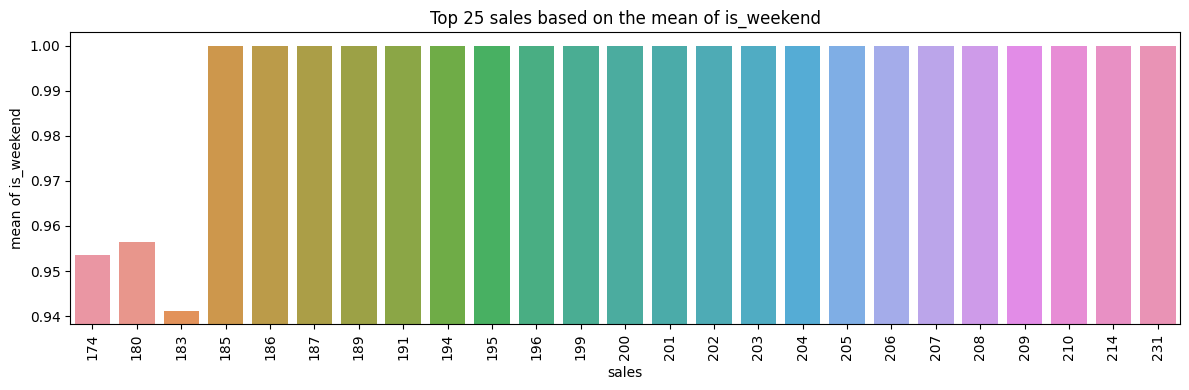

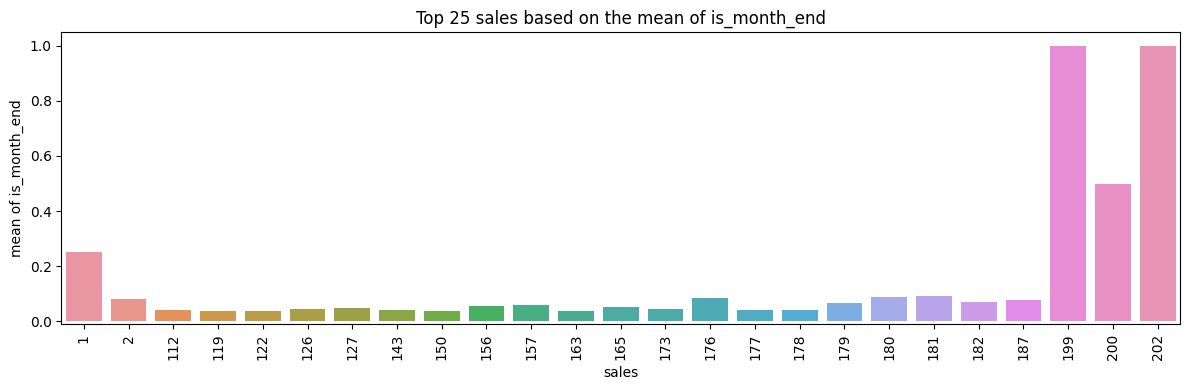

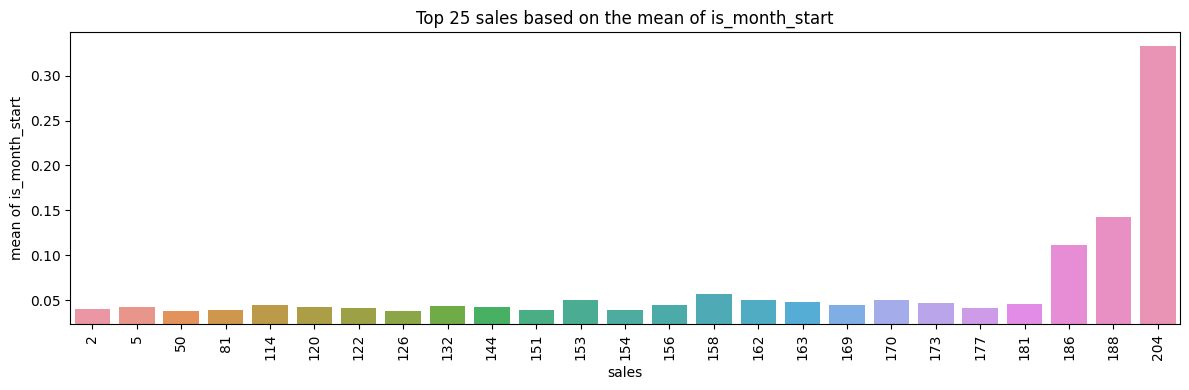

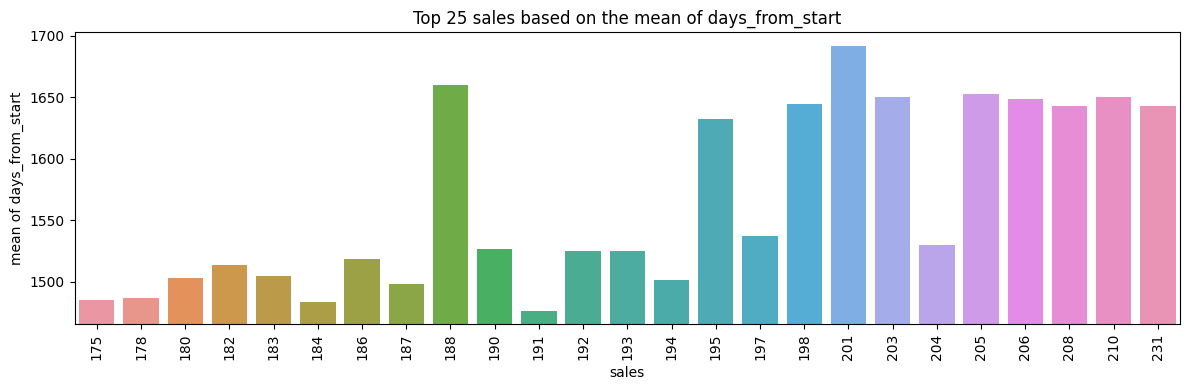

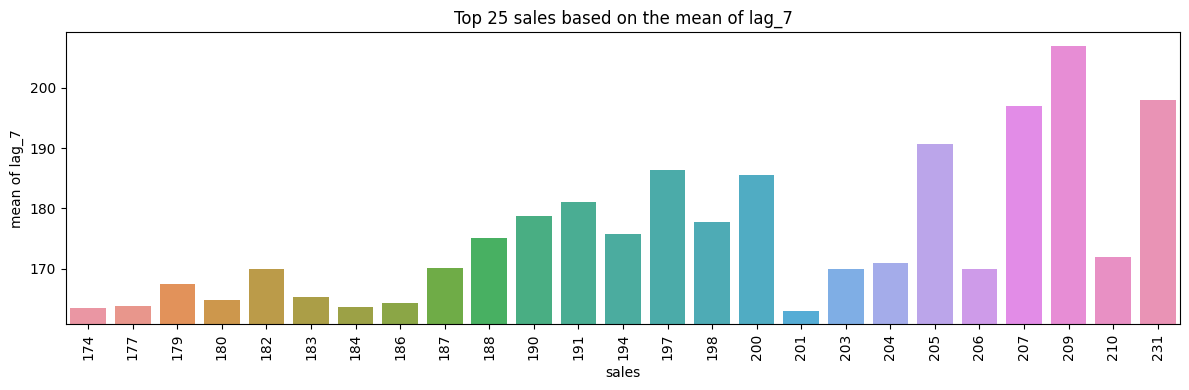

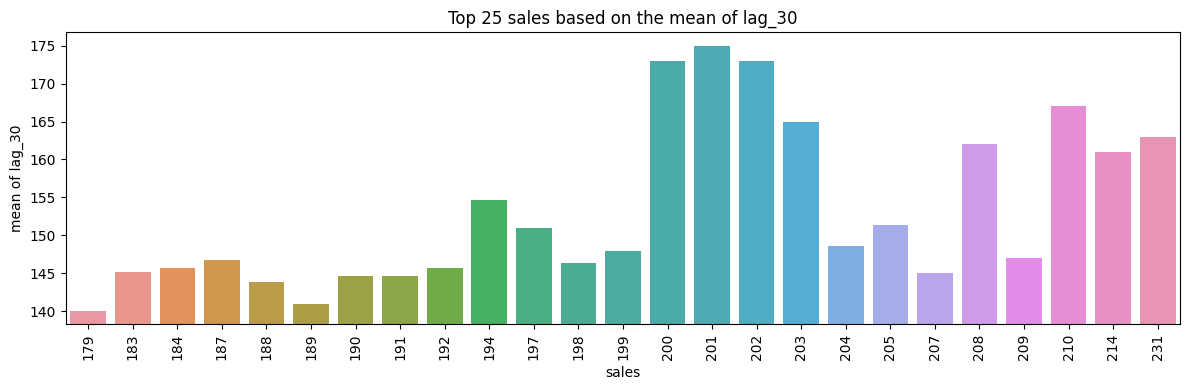

In [50]:
n = 25
for col in float_features:
    top_artists = df.groupby('sales')[col].mean().sort_values(ascending=False)
    plot_top_n(top_artists.head(n), 'sales', f'mean of {col}', n)

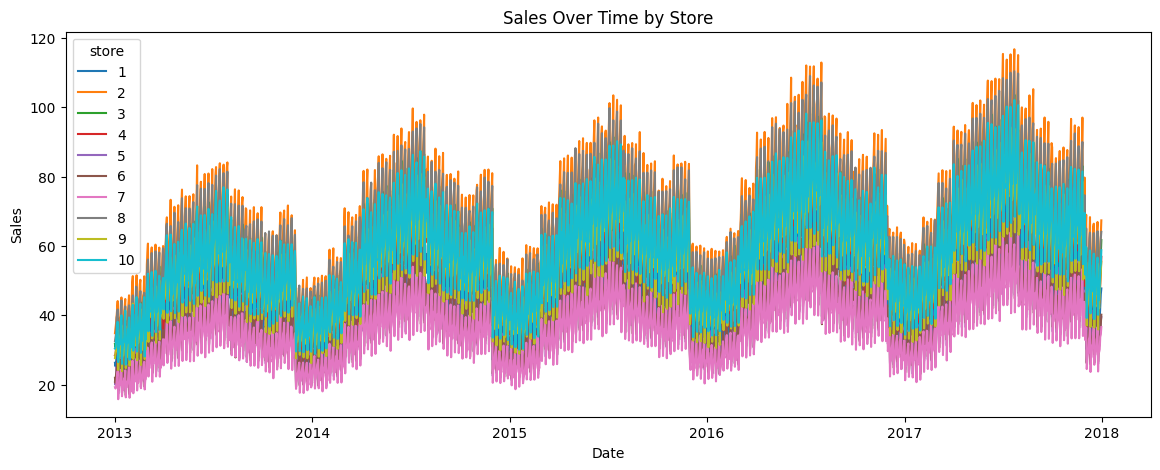

In [51]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=df, x="date", y="sales", hue="store", palette="tab10", ci=None)
plt.title("Sales Over Time by Store")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# Multiple Feature Analysis

In [52]:
def plot_pos_neg(df, columns, plot_func, y_col, size=(12, 4), n_col=1):
    if len(columns) == 0:
        return
    n_rows = (len(columns) + n_col-1) // n_col
    fig, axes = plt.subplots(n_rows, n_col, figsize=(size[0]*n_col, size[1]*n_rows))
    if len(columns) == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, label in enumerate(columns):
        plot_func(df[df[y_col] >= df[y_col].median()], x=label, kde=True, color='green', label='Above Median', element='step', alpha=0.5, ax=axes[i])
        plot_func(df[df[y_col] <  df[y_col].median()], x=label, kde=True, color='red',   label='Below Median', element='step', alpha=0.5, ax=axes[i])
        axes[i].set_xlabel(label)
        axes[i].set_title(f'Above Median vs. Below Median {y_col} for {label}')

    for j in range(i+1, n_rows*n_col):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

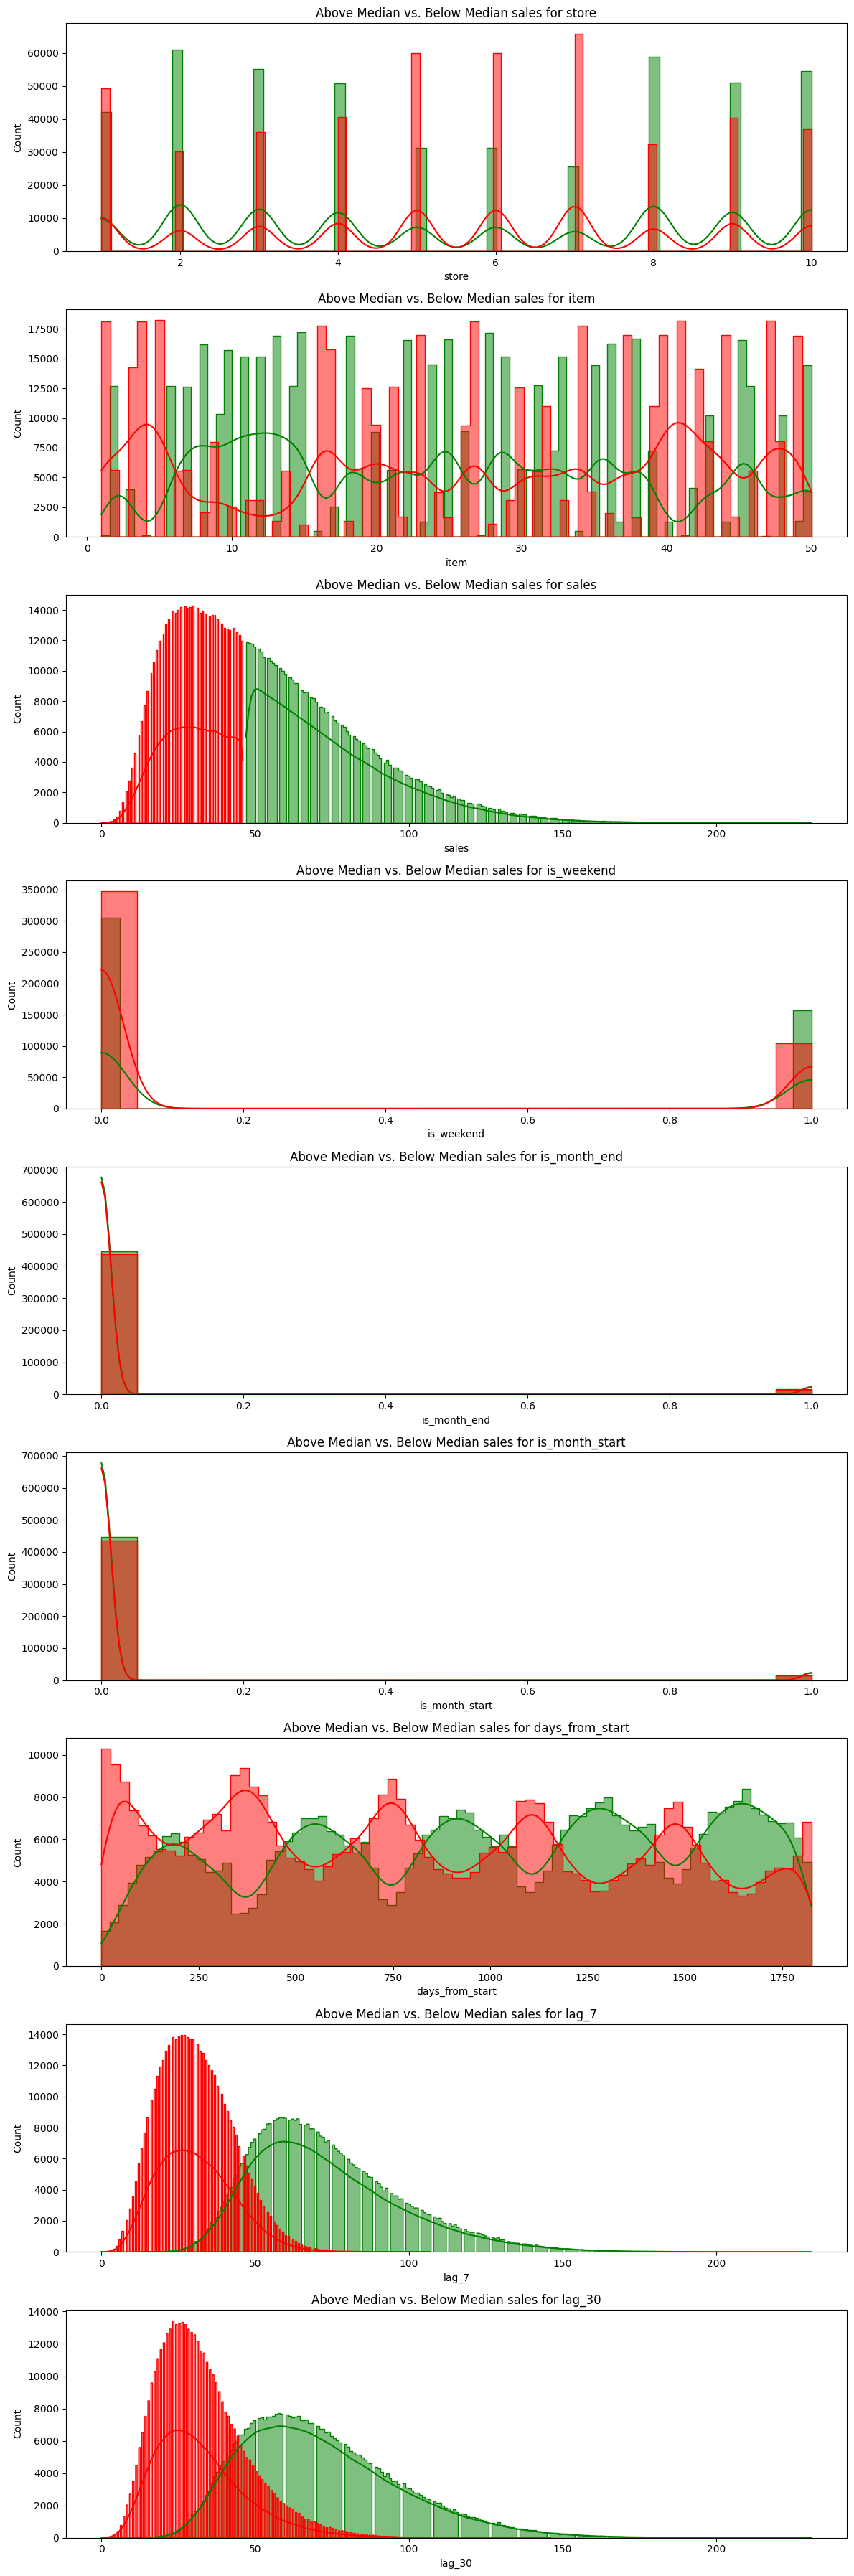

In [53]:
plot_pos_neg(df, float_features, sns.histplot, 'sales')

# Predictive Models

In [54]:
train_test_df = pd.concat([df, test])
train_test_df_dummy = pd.get_dummies(train_test_df)

In [55]:
df_dummy, test_dummy = train_test_df_dummy[:len(df)], train_test_df_dummy[len(df):]
test_dummy = test_dummy.drop(columns=['sales'])

In [56]:
df_dummy.head(10)

,date,store,item,sales,year,month,day,weekday,weekofyear,is_weekend,...,store_item_9_46,store_item_9_47,store_item_9_48,store_item_9_49,store_item_9_5,store_item_9_50,store_item_9_6,store_item_9_7,store_item_9_8,store_item_9_9
0,2013-01-01,1,1,13.0,2013,1,1,1,1,0,...,False,False,False,False,False,False,False,False,False,False
1,2013-01-02,1,1,11.0,2013,1,2,2,1,0,...,False,False,False,False,False,False,False,False,False,False
2,2013-01-03,1,1,14.0,2013,1,3,3,1,0,...,False,False,False,False,False,False,False,False,False,False
3,2013-01-04,1,1,13.0,2013,1,4,4,1,0,...,False,False,False,False,False,False,False,False,False,False
4,2013-01-05,1,1,10.0,2013,1,5,5,1,1,...,False,False,False,False,False,False,False,False,False,False
5,2013-01-06,1,1,12.0,2013,1,6,6,1,1,...,False,False,False,False,False,False,False,False,False,False
6,2013-01-07,1,1,10.0,2013,1,7,0,2,0,...,False,False,False,False,False,False,False,False,False,False
7,2013-01-08,1,1,9.0,2013,1,8,1,2,0,...,False,False,False,False,False,False,False,False,False,False
8,2013-01-09,1,1,12.0,2013,1,9,2,2,0,...,False,False,False,False,False,False,False,False,False,False
9,2013-01-10,1,1,9.0,2013,1,10,3,2,0,...,False,False,False,False,False,False,False,False,False,False


In [57]:
print(f'df_dummy.columns   : {df_dummy.columns}')
print(f'df_dummy.shape     : {df_dummy.shape}')

df_dummy.columns   : Index(['date', 'store', 'item', 'sales', 'year', 'month', 'day', 'weekday',
       'weekofyear', 'is_weekend',
       ...
       'store_item_9_46', 'store_item_9_47', 'store_item_9_48',
       'store_item_9_49', 'store_item_9_5', 'store_item_9_50',
       'store_item_9_6', 'store_item_9_7', 'store_item_9_8', 'store_item_9_9'],
      dtype='object', length=516)
df_dummy.shape     : (913000, 516)


In [58]:
dtype_str = df_dummy.dtypes.apply(lambda x: str(x))
dtypes_cnt = dtype_str.groupby(dtype_str).size()
dtypes_col = df_dummy.columns.groupby(dtype_str)

In [59]:
print("dtypes_cnt    :", dtypes_cnt.to_dict())
print("dtypes_col    :", dtypes_col)

dtypes_cnt    : {'UInt32': 1, 'bool': 500, 'datetime64[ns]': 1, 'float64': 4, 'int32': 4, 'int64': 6}
dtypes_col    : {'UInt32': ['weekofyear'], 'bool': ['store_item_10_1', 'store_item_10_10', 'store_item_10_11', 'store_item_10_12', 'store_item_10_13', 'store_item_10_14', 'store_item_10_15', 'store_item_10_16', 'store_item_10_17', 'store_item_10_18', 'store_item_10_19', 'store_item_10_2', 'store_item_10_20', 'store_item_10_21', 'store_item_10_22', 'store_item_10_23', 'store_item_10_24', 'store_item_10_25', 'store_item_10_26', 'store_item_10_27', 'store_item_10_28', 'store_item_10_29', 'store_item_10_3', 'store_item_10_30', 'store_item_10_31', 'store_item_10_32', 'store_item_10_33', 'store_item_10_34', 'store_item_10_35', 'store_item_10_36', 'store_item_10_37', 'store_item_10_38', 'store_item_10_39', 'store_item_10_4', 'store_item_10_40', 'store_item_10_41', 'store_item_10_42', 'store_item_10_43', 'store_item_10_44', 'store_item_10_45', 'store_item_10_46', 'store_item_10_47', 'store_ite

In [60]:
df_dummy.select_dtypes(include=['int64', 'float64']).describe()

,store,item,sales,is_weekend,is_month_end,is_month_start,days_from_start,lag_7,lag_30,id
count,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,909500.00000,898000.000000,0.0
mean,5.500000,25.500000,52.250287,0.285871,0.032859,0.032859,912.500000,52.28043,52.375058,NaN
std,2.872283,14.430878,28.801144,0.451828,0.178267,0.178267,527.121005,28.81846,28.876637,NaN
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN
25%,3.000000,13.000000,30.000000,0.000000,0.000000,0.000000,456.000000,30.00000,30.000000,NaN
50%,5.500000,25.500000,47.000000,0.000000,0.000000,0.000000,912.500000,47.00000,47.000000,NaN
75%,8.000000,38.000000,70.000000,1.000000,0.000000,0.000000,1369.000000,70.00000,70.000000,NaN
max,10.000000,50.000000,231.000000,1.000000,1.000000,1.000000,1825.000000,231.00000,231.000000,NaN


In [61]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 913000 entries, 0 to 912999
Columns: 516 entries, date to store_item_9_9
dtypes: UInt32(1), bool(500), datetime64[ns](1), float64(4), int32(4), int64(6)
memory usage: 537.2 MB


In [62]:
df_dummy.select_dtypes(include=['float64']).isna().sum()

sales          0
lag_7       3500
lag_30     15000
id        913000
dtype: int64

In [63]:
df_dummy.select_dtypes(include=['int64', 'float64']).describe()

,store,item,sales,is_weekend,is_month_end,is_month_start,days_from_start,lag_7,lag_30,id
count,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,909500.00000,898000.000000,0.0
mean,5.500000,25.500000,52.250287,0.285871,0.032859,0.032859,912.500000,52.28043,52.375058,NaN
std,2.872283,14.430878,28.801144,0.451828,0.178267,0.178267,527.121005,28.81846,28.876637,NaN
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN
25%,3.000000,13.000000,30.000000,0.000000,0.000000,0.000000,456.000000,30.00000,30.000000,NaN
50%,5.500000,25.500000,47.000000,0.000000,0.000000,0.000000,912.500000,47.00000,47.000000,NaN
75%,8.000000,38.000000,70.000000,1.000000,0.000000,0.000000,1369.000000,70.00000,70.000000,NaN
max,10.000000,50.000000,231.000000,1.000000,1.000000,1.000000,1825.000000,231.00000,231.000000,NaN


In [64]:
import statistics
import lightgbm as lgb
import catboost as cat
import xgboost as xgb

from sklearn.metrics         import mean_squared_error, \
                                    mean_absolute_error, \
                                    mean_squared_log_error, \
                                    r2_score
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler, \
                                    OneHotEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.impute          import SimpleImputer

from sklearn.svm             import SVR
from sklearn.tree            import DecisionTreeRegressor
from sklearn.linear_model    import LinearRegression, \
                                    BayesianRidge, \
                                    Ridge, \
                                    LassoCV
from sklearn.model_selection import KFold, \
                                    cross_val_score, \
                                    train_test_split
from sklearn.ensemble        import GradientBoostingRegressor, \
                                    RandomForestRegressor, \
                                    ExtraTreesRegressor, \
                                    AdaBoostRegressor, \
                                    BaggingRegressor, \
                                    StackingRegressor, \
                                    VotingRegressor
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.neural_network  import MLPRegressor

In [65]:
target = 'sales'
y = df_dummy[target]
X = df_dummy.drop(columns=[target])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

In [67]:
models = {
    'ExtraTreesRegressor':       ExtraTreesRegressor(),
    'CatBoostRegressor':         cat.CatBoostRegressor(silent=True),
    'XGBRegressor':              xgb.XGBRegressor(
                                    colsample_bytree=0.4603, 
                                    gamma=0.0468, 
                                    learning_rate=0.05, 
                                    max_depth=3, 
                                    min_child_weight=1.7817, 
                                    n_estimators=2200,
                                    reg_alpha=0.4640, 
                                    reg_lambda=0.8571,
                                    subsample=0.5213
                                 ),
    'LGBMRegressor':             lgb.LGBMRegressor(
                                    objective='regression',
                                    num_leaves=5,
                                    learning_rate=0.05, 
                                    n_estimators=720,
                                    max_bin = 55, 
                                    bagging_fraction = 0.8,
                                    bagging_freq = 5, 
                                    feature_fraction = 0.2319,
                                    feature_fraction_seed=9, 
                                    bagging_seed=9,
                                    min_data_in_leaf =6, 
                                    min_sum_hessian_in_leaf = 11
                                 ),
}

In [68]:
def evaluate_model(pipeline, X, y, kf):
    cv_mae = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_absolute_error')
    cv_mse = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_squared_error')
    cv_r2  = cross_val_score(pipeline, X, y, cv=kf, scoring='r2')
    
    mae = -statistics.mean(cv_mae)
    mse = -statistics.mean(cv_mse)
    rmse = np.sqrt(mse)
    r2 = statistics.mean(cv_r2)
    
    return mae, mse, rmse, r2

In [69]:
results = {}

kf = KFold(n_splits=5, shuffle=True)

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    mae, mse, rmse, r2 = evaluate_model(pipeline, X, y, kf)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R^2': r2
    }

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319

In [70]:
results_df = pd.DataFrame(results).T
results_df

,MAE,MSE,RMSE,R^2
ExtraTreesRegressor,8.031531,109.523184,10.465332,0.867773
CatBoostRegressor,6.624711,74.534787,8.633353,0.910139
XGBRegressor,6.865217,80.216622,8.956373,0.903339
LGBMRegressor,7.481497,94.967490,9.745126,0.885727


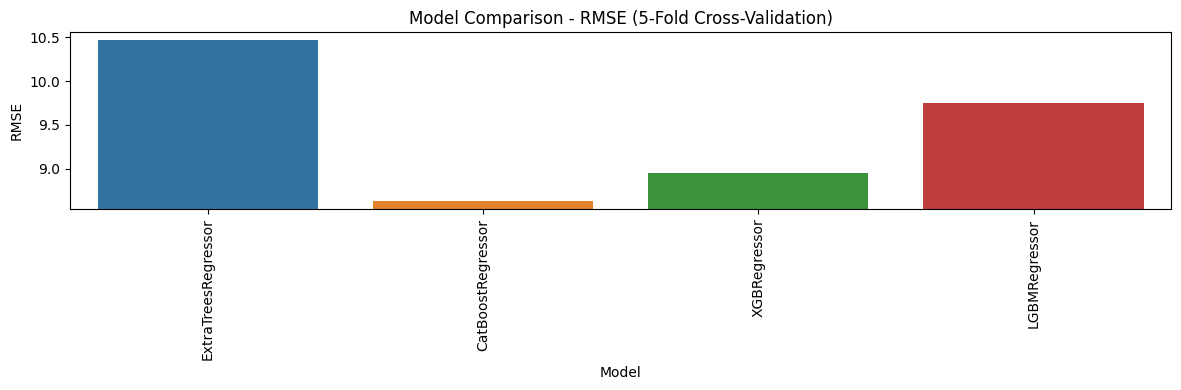

In [71]:
results_df.reset_index(inplace=True)
rmse_df = results_df[['index', 'RMSE']]

plt.figure(figsize=(12, 4))
sns.barplot(data=rmse_df, x='index', y='RMSE')

plt.title("Model Comparison - RMSE (5-Fold Cross-Validation)")
plt.xlabel("Model")
plt.ylabel("RMSE")
yminlim = rmse_df['RMSE'].min()
ymaxlim = rmse_df['RMSE'].max()
yrange = (ymaxlim - yminlim) * .05
yminlim -= yrange
ymaxlim += yrange
plt.ylim(yminlim, ymaxlim)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [72]:
best_regressor_name = results_df.sort_values(by=['RMSE']).head(1)['index'].iloc[0]
best_regressor = models[best_regressor_name]

In [73]:
best_model = best_regressor.fit(X_train, y_train)

In [74]:
pred = best_model.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

8.132613547280043

# Submission

In [75]:
submission = pd.DataFrame(test['id'], columns = ['id'])
submission['sales'] = best_model.predict(test_dummy)
submission['sales'] = np.expm1(submission['sales'])
submission.head()

,id,sales
0,0,8.403478e+05
1,1,4.676831e+06
2,2,2.157342e+07
3,3,2.332400e+07
4,4,1.909547e+08


In [76]:
submission.to_csv("submission.csv", index = False, header = True)